In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
d_model = 256
num_heads = 4
num_layers = 2
drop_prob = 0.1
learning_rate = 0.001
batch_size = 16
num_epochs = 8
max_seq_length = 300
ffn_hidden = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # if there is one

In [3]:
d_model

256

In [4]:
# Get the number of CPU cores
num_cores = os.cpu_count()

# Set PyTorch to use all available CPU threads
torch.set_num_threads(num_cores)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Set the number of threads explicitly
print(f"Number of threads PyTorch will use: {torch.get_num_threads()}")

Using device: cpu
Number of threads PyTorch will use: 11


In [5]:

class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_model, hidden, drop_prob=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, hidden).to(device)  # Move layer to device
        self.linear2 = nn.Linear(hidden, d_model).to(device)  # Move layer to device
        self.relu = nn.ReLU().to(device)  # Move activation to device
        self.dropout = nn.Dropout(p=drop_prob).to(device)  # Move dropout to device

    def forward(self, x):
        x = x.to(device)  # Move input to device
        x = self.linear1(x)
        # print(f"x after first linear layer: {x.size()}")
        x = self.relu(x)
        # print(f"x after activation: {x.size()}")
        x = self.dropout(x)
        # print(f"x after dropout: {x.size()}")
        x = self.linear2(x)
        # print(f"x after 2nd linear layer: {x.size()}")
        return x

In [6]:

class PositionEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        self.max_seq_length = max_seq_length
        self.d_model = d_model

        # Compute the position encodings
        even_i = torch.arange(0, d_model, 2).float().to(device)
        denominator = torch.pow(10000, even_i / d_model).to(device)
        position = torch.arange(max_seq_length).reshape(max_seq_length, 1).to(device)
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2).to(device)
        self.position_encoding = torch.flatten(stacked, start_dim=1, end_dim=2)  # Shape: [max_seq_length, d_model]

    def forward(self, x):
        x = x.to(device)  # Move input to device

        # Get the batch size and sequence length
        batch_size, seq_len, d_model = x.size(0), x.size(1), x.size(2)

        # Dynamically slice the positional encoding
        if seq_len > self.max_seq_length:
            raise ValueError(f"Sequence length ({seq_len}) exceeds max_seq_length ({self.max_seq_length})!")
        position_encoding = self.position_encoding[:seq_len, :]  # Shape: [seq_len, d_model]
        #print(f"Sliced position encoding shape: {position_encoding.shape}")
        
        # Expand positional encoding to match batch size
        position_encoding = position_encoding.unsqueeze(0).expand(batch_size, -1, -1)  # Shape: [batch_size, seq_len, d_model]
        #print(f" Broadcasted position encoding shape: {position_encoding.shape}")

        # Add positional encoding to the input
        output = x + position_encoding

        #print(f" Output tensor shape after addition: {output.shape}")

        return output


In [7]:
def scaled_dot_product(q, k, v, mask=None):

    # Step 1: Compute the scaled dot-product (Q * K^T)
    d_k = q.size(-1)  # This is the dimension of the keys (and queries)
    scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

    # Step 2: Apply mask (if provided)
    if mask is not None:
        # Adjust the mask shape
        if mask.ndimension() == 4:
            if mask.shape[1] == 1:  # Handle case like (batch_size, 1, seq_len_q, seq_len_k)
                mask = mask.expand(-1, q.size(1), -1, -1)  # Broadcast to match num_heads
            elif mask.shape == scaled.shape:
                print("Mask is already correctly shaped for attention.")
            else:
                raise ValueError(f"Unexpected 4D mask shape: {mask.shape}")
        elif mask.ndimension() == 2:
            if mask.shape[0] == q.size(0):  # Padding mask: (batch_size, seq_len)
                mask = mask.unsqueeze(1).unsqueeze(2)  # Shape: (batch_size, 1, 1, seq_len)
                mask = mask.expand(-1, q.size(1), q.size(2), -1)  # Shape: (batch_size, num_heads, seq_len_q, seq_len_k)
            elif mask.shape[0] == mask.shape[1]:  # Causal mask: (seq_len, seq_len)
                mask = mask.unsqueeze(0).unsqueeze(1)  # Shape: (1, 1, seq_len, seq_len)
                mask = mask.expand(q.size(0), q.size(1), -1, -1)  # Shape: (batch_size, num_heads, seq_len_q, seq_len_k)
            else:
                raise ValueError(f"Unexpected 2D mask shape: {mask.shape}")
        elif mask.ndimension() == 3:
            # Explicit case for (batch_size, seq_len_q, seq_len_k)
            mask = mask.unsqueeze(1)  # Shape: (batch_size, 1, seq_len_q, seq_len_k)
            mask = mask.expand(-1, q.size(1), -1, -1)  # Shape: (batch_size, num_heads, seq_len_q, seq_len_k)
        else:
            raise ValueError(f"Unexpected mask dimensions: {mask.shape}")
        
        # Add the mask (assumes additive masking with -inf for masked positions)
        scaled = scaled + mask

    # Step 3: Apply softmax to get attention weights
    attention = F.softmax(scaled, dim=-1)  # Shape: (batch_size, num_heads, seq_len_q, seq_len_k)

    # Step 4: Multiply attention weights with values (Q * Attention * V)
    values = torch.matmul(attention, v)  # Shape: (batch_size, num_heads, seq_len_q, d_v)

    return attention, values

In [8]:
def scaled_dot_product_inference(q, k, v, mask=None):
    # Ensure all inputs are in the same data type (float32 for attention mechanism)
    dtype = torch.float32  # Use float32 for consistency in attention computations
    #print(f"Initial data types - q: {q.dtype}, k: {k.dtype}, v: {v.dtype}")

    # Cast q, k, v to float32 if they are not already
    q = q.to(dtype)
    k = k.to(dtype)
    v = v.to(dtype)
    #print(f"Data types after casting - q: {q.dtype}, k: {k.dtype}, v: {v.dtype}")

    # Step 1: Compute the scaled dot-product (Q * K^T)
    d_k = q.size(-1)  # Dimension of keys (and queries)
    #print(f"Query shape: {q.shape}, Key shape: {k.shape}, Value shape: {v.shape}, d_k: {d_k}")

    # Make sure q and k have compatible shapes for multiplication
    assert q.size(-1) == k.size(-1), f"Shape mismatch: {q.shape} vs {k.shape}"

    scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    #print(f"Scaled dot product shape: {scaled.shape}")

    # Step 2: Apply mask (if provided)
    if mask is not None:
        #print(f"Mask provided, mask shape: {mask.shape}")
        # Apply mask (same as before)
        mask = mask.to(dtype)
        scaled = scaled + mask
        #print(f"Scaled with mask applied, shape: {scaled.shape}")

    # Step 3: Apply softmax to get attention weights
    attention = F.softmax(scaled, dim=-1)  # Shape: (batch_size, num_heads, seq_len_q, seq_len_k)
    #print(f"Attention shape: {attention.shape}")

    # Step 4: Multiply attention weights with values (Q * Attention * V)
    values = torch.matmul(attention, v)  # Shape: (batch_size, num_heads, seq_len_q, d_v)
    #print(f"Values shape: {values.shape}")

    return attention, values

In [9]:

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, d_model):
        super().__init__()
        self.d_model = d_model  # 512
        self.num_heads = num_heads  # 8
        self.head_dim = d_model // num_heads  # 64
        self.qkv_layer = nn.Linear(d_model, 3*d_model).to(device)  # 512 x 1536
        self.linear_layer = nn.Linear(d_model, d_model).to(device)  # 512 x 512

    def forward(self, x, mask=None):
        x = x.to(device)  # Move input to device
        if mask is not None:
            mask = mask.to(device)

        #print(f"x.shape = {x.shape}")
        batch_size, max_seq_length, d_model = x.size()
        #print(f"x.size() = {x.size()}")
        qkv = self.qkv_layer(x)
        #print(f"x after going through qkv layer - {qkv.size()}")
        qkv_reshape = qkv.reshape(batch_size, max_seq_length, self.num_heads, 3*self.head_dim)
        #print("--- Entering MultiHeadedAttention ---")
        #print(f"qkv reshaped shape is {qkv_reshape.size()}")
        qkv_permute = qkv_reshape.permute(0,2,1,3)
        #print(f"QKV Permuted Shape is - {qkv_permute.size()}")
        #print("--- Dividing QKV into individual tensors ---")
        q, k, v = qkv_permute.chunk(3, dim=-1)
        #print("Now q, k, v tensors are passed into the Attention Calculation")
        attention, values = scaled_dot_product(q, k, v, mask=mask)
        #print("Now we get the Attention Scores and New Values")
        #print(f"Values shape we get from scaled dot product attention is - {values.size()}")
        #print("Now we concatinate the values received from scaled dot product.")
        values_reshaped = values.permute(0,2,1,3).reshape(batch_size, max_seq_length, self.num_heads * self.head_dim)
        #print(f"New Values from Multiheaded attention output shape is - {values_reshaped.size()}")
        output = self.linear_layer(values_reshaped)
        #print(f"Final Output shape from multiheaded attention heads - {output.size()}")
        return output


In [10]:
class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape = parameters_shape
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape)).to(device)
        self.beta = nn.Parameter(torch.zeros(parameters_shape)).to(device)

    def forward(self, inputs):
        inputs = inputs.to(device)  # Move input to device
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True)
        #print(f"Shape of the Mean after preserving the dimensions - {mean.size()}")
        var = ((inputs - mean)**2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()
        #print(f"Standard Deviation is {std.size()}")
        normalized_out = (inputs - mean) / std
        normalized_out = (normalized_out * self.gamma) + self.beta
        #print("Normalized value is Multiplied and Added with Learnable Parameters Gamma and Beta")
        #print(f"Shape of gamma and beta are - {self.gamma.size()} and {self.beta.size()}")
        #print(f"Layer Normalized Output shape is {normalized_out.size()}")
        return normalized_out



In [11]:
## Putting it all together 
class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super().__init__()
        self.attention_layer = MultiHeadAttention(num_heads=num_heads, d_model=d_model).to(device)
        self.layer_normalizer1 = LayerNormalization(parameters_shape=[d_model]).to(device)
        self.dropout1 = nn.Dropout(p=drop_prob).to(device)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob).to(device)
        self.layer_normalizer2 = LayerNormalization(parameters_shape=[d_model]).to(device)
        self.dropout2 = nn.Dropout(p=drop_prob).to(device)

    def forward(self, x, mask=None):
        x = x.to(device)  # Move input to device
        if mask is not None:
            mask = mask.to(device)
        
        residual_x = x
        #print(f"Encoder Attention Mask shape: {mask.shape}")
        #print(mask)
        #print("----- Attention Layer 1 ----")
        x = self.attention_layer(x, mask=mask)
        #print(f"Output shape from Multi Head Attention - {x.size()}")
        #print("---- Dropout 1 ----")
        x = self.dropout1(x)
        #print(f"x shape after passing through dropout Layer 1 - {x.size()}")
        #print("----- Add and Normalizer 1 ---")
        x = self.layer_normalizer1(residual_x + x)
        #print(f"x shape after passing through layer normalizer 1 - {x.size()}")
        residual_x = x
        #print("---- Attention 2 through ffn ----")
        x = self.ffn(x)
        #print("----- Dropout 2 -----")
        x = self.dropout2(x)
        #print("----- Add and Normalizer 2 ---")
        x = self.layer_normalizer2(residual_x + x)
        return x

In [12]:
## Encoder Block

class EncoderBlock(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers):
        super().__init__()
        self.layers = nn.Sequential(*[EncoderLayer(d_model=d_model, ffn_hidden=ffn_hidden, num_heads=num_heads, drop_prob=drop_prob).to(device) 
                                       for _ in range(num_layers)])
    
    def forward(self, x, mask=None):
        x = x.to(device)  # Move input to device
        if mask is not None:
            mask = mask.to(device)
        
        for layer in self.layers:
            x = layer(x, mask)
        return x 

In [13]:
encoder = EncoderBlock(d_model, ffn_hidden, num_heads,drop_prob, num_layers)

In [14]:
class MultiHeadedCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model, 2*d_model).to(device)
        self.q_layer = nn.Linear(d_model, d_model).to(device)
        self.linear_layer = nn.Linear(d_model, d_model).to(device)

    def forward(self, x, y, mask=None):
        x, y = x.to(device), y.to(device)  # Move inputs to device
        if mask is not None:
            mask = mask.to(device)

        batch_size, encoder_max_seq_length, d_model = x.size()
        _, decoder_max_seq_len, _ = y.size()
        #print("This is the input to the Decoder Layer Cross Attention from Masked Attention from")
        #print(f"The shape of the input x which comes from Encoder is {x.size()}")
        #print("The shape of cross attention mask used in Multi Headed Cross Attention is -", mask.shape)
        
        # Keys and values for cross attention will be coming from encoder layer
        kv = self.kv_layer(x)
        #print("The Keys and Values for Cross Attention will be coming from Encoder Layer")
        #print(f"The shape of kv is {kv.size()}")
        #print("batch size: ", batch_size)
        #print("max_seq_len:", encoder_max_seq_length)
        #print("num heads: ", self.num_heads)
        #print("head_dim: ", self.head_dim)
        
        #print("Query matrix will be coming from masked self-attention head from decoder")
        q = self.q_layer(y)
        #print("The y which is the query matrix will be coming from the masked self attention head from Decoder.")
        #print(f"The shape of q is {q.size()}")
        #print(f"The shape of kv coming from encoder layer is - {kv.size()}")
        
        kv = kv.reshape(batch_size, encoder_max_seq_length, self.num_heads, 2*self.head_dim)
        #print("kv reshaped shape is  - ", kv.shape)
        q = q.reshape(batch_size, decoder_max_seq_len, self.num_heads, self.head_dim)
        #print("q reshaped shape is  -", q.shape)
        # q shape is 30 x 200 x 8 x 64
        # k, v shape is 30 x 200 x 8 x 128
        # The shape we want is q = 30 x 8 x 200 x 64
        # The shape we want for k, v = 30 x 8 x 200 x 128
        kv = kv.permute(0,2,1,3)
        q = q.permute(0,2,1,3)
        k, v = kv.chunk(2, dim=-1)
        #print("kv and q after permuted and kv after chunk. Final shapes will be of q,k,v- ",q.shape, k.shape, v.shape)
        # the shape of k, v = 30 x 8 x 200 x 64

        attention, values = scaled_dot_product(q, k, v, mask=mask)
        #print(f"Values and Attention shapes are {values.size()} and {attention.size()}")
        values = values.permute(0,2,1,3).reshape(batch_size, decoder_max_seq_len, self.num_heads * self.head_dim)
        #print(f"The contextualized values will be reshaped by 'values.reshape(batch_size, max_seq_length, self.num_heads * self.head_dim)'")
        #print(f"The contextualized values will be of shape {values.size()}")
        out = self.linear_layer(values)
        #print(f"Values passing through a linear layer and returns output with shape - {out.size()}")
        return out  # 30 x 200 x 512

In [15]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, drop_prob, num_heads):
        super().__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads).to(device)
        self.layer_norm1 = LayerNormalization(parameters_shape=[d_model]).to(device)
        self.dropout1 = nn.Dropout(p=drop_prob).to(device)
        self.encoder_decoder_cross_attention = MultiHeadedCrossAttention(d_model=d_model, num_heads=num_heads).to(device)
        self.layer_norm2 = LayerNormalization(parameters_shape=[d_model]).to(device)
        self.dropout2 = nn.Dropout(p=drop_prob).to(device)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob).to(device)
        self.layer_norm3 = LayerNormalization(parameters_shape=[d_model]).to(device)
        self.dropout3 = nn.Dropout(p=drop_prob).to(device)

    def forward(self, x, y, decoder_self_attention_mask=None, cross_attention_mask=None):
        x, y = x.to(device), y.to(device)  # Move inputs to device
        if decoder_self_attention_mask is not None:
            decoder_self_attention_mask = decoder_self_attention_mask.to(device)
        if cross_attention_mask is not None:
            cross_attention_mask = cross_attention_mask.to(device)

        #print(f"Initial input to DecoderLayer x: {x.shape}, y: {y.shape}")  
        #print("Mask shapes used in decoder layer are - ")
        #print("The shape of decoder masked attention - ", decoder_self_attention_mask.shape)
        #print("The shape of encoder decoder cross attention mask is - ", cross_attention_mask.shape)

        residual_y = y
        #print("----ENTERING MASKED ATTENTION----")
        y = self.self_attention(y, mask=decoder_self_attention_mask)
        #print(f"Output of masked self-attention: {y.shape}")  

        y = self.dropout1(y)
        #print(f"After dropout 1: {y.shape}")

        y = self.layer_norm1(residual_y + y)
        #print(f"After layer norm 1: {y.shape}")

        residual_y = y
        y = self.encoder_decoder_cross_attention(x, y, mask=cross_attention_mask)
        #print(f"Output of cross attention: {y.shape}")

        y = self.dropout2(y)
        #print(f"After dropout 2: {y.shape}")

        y = self.layer_norm2(residual_y + y)
        #print(f"After layer norm 2: {y.shape}")

        residual_y = y
        y = self.ffn(y)
        #print(f"After feed-forward network: {y.shape}")

        y = self.dropout3(y)
        #print(f"After dropout 3: {y.shape}")

        y = self.layer_norm3(residual_y + y)
        #print(f"Final output from DecoderLayer: {y.shape}")
        return y

In [16]:
class SequentialDecoder(nn.Sequential):
    #         self._modules is a dictionary of all the layers stored in the SequentialDecoder (inherited from nn.Sequential).
    #         self._modules.values() gives a list of the layers in the order they were added.

    def forward(self, x, y, decoder_self_attention_mask=None, cross_attention_mask=None):
        x, y = x.to(device), y.to(device)  # Move inputs to device
        if decoder_self_attention_mask is not None:
            decoder_self_attention_mask = decoder_self_attention_mask.to(device)
        if cross_attention_mask is not None:
            cross_attention_mask = cross_attention_mask.to(device)

        for module in self._modules.values():
            y = module(x, y, decoder_self_attention_mask, cross_attention_mask)
        return y

In [17]:
class Decoder(nn.Sequential):
    def __init__(self, d_model, num_heads, ffn_hidden, drop_prob, num_layers, device = device):
        super().__init__()
        self.layers = SequentialDecoder(*[
            DecoderLayer(d_model=d_model,
                         ffn_hidden=ffn_hidden,
                         drop_prob=drop_prob,
                         num_heads=num_heads).to(device)
            for _ in range(num_layers)
        ])

    def forward(self, x, y, decoder_self_attention_mask=None, cross_attention_mask=None):
        x, y = x.to(device), y.to(device)  # Move inputs to device
        if decoder_self_attention_mask is not None:
            decoder_self_attention_mask = decoder_self_attention_mask.to(device)
        if cross_attention_mask is not None:
            cross_attention_mask = cross_attention_mask.to(device)
        
        # x shape is 30 x 200 x 512
        # y shape is 30 x 200 x 512
        return self.layers(x, y, decoder_self_attention_mask, cross_attention_mask)


In [18]:
decoder = Decoder(
    d_model=d_model,
    num_heads=num_heads,
    ffn_hidden=ffn_hidden,
    drop_prob=drop_prob,
    num_layers=num_layers,
    device=device)

In [19]:
with open('/Users/venu/Documents/Productivity/Pytorch Tutorials/en-te/English_Text.txt', "r") as english_file_te_trans:
    source_eng_to_te_text = english_file_te_trans.readlines()

with open('/Users/venu/Documents/Productivity/Pytorch Tutorials/en-te/Telugu_Text.txt', "r") as telugu_file:
    telugu_text = telugu_file.readlines()

with open('/Users/venu/Documents/Productivity/Pytorch Tutorials/en-hi/english_text.txt',"r") as english_file_hi_trans:
    source_eng_to_hi_text = english_file_hi_trans.readlines()

with open('/Users/venu/Documents/Productivity/Pytorch Tutorials/en-hi/hindi_text.txt', "r") as hindi_file:
    hindi_text = hindi_file.readlines()

In [20]:
source_eng_to_te_text[-1000], telugu_text[-1000]

('But in BJP this does not happen. \n', 'కానీ బీజేపీ అలా వివక్ష చూపించదు. \n')

In [21]:
source_eng_to_hi_text[-1000], hindi_text[-1000]

('This trend is ominous.\n', 'यह प्रवृत्ति देशघाती है।\n')

In [22]:
len(source_eng_to_te_text), len(telugu_text), len(source_eng_to_hi_text), len(hindi_text)

(4946036, 4946036, 8568307, 8568307)

In [23]:
SAMPLE_NUM = 42000

In [24]:
source_eng_tel_trans = source_eng_to_te_text[-SAMPLE_NUM:]
target_telugu = telugu_text[-SAMPLE_NUM:]
source_eng_hin_trans = source_eng_to_hi_text[:SAMPLE_NUM]
target_hindi = hindi_text[:SAMPLE_NUM]

In [25]:
source_eng_tel_trans[:2], target_telugu[:2], source_eng_hin_trans[:2], target_hindi[:2]

(['Shri Tomar also expressed gratitude to Prime Minister Shri Narendra Modi for bringing in long-awaited agricultural reforms by announcing legal amendments and ordinances which will empower the farmers and help them in getting remunerative prices for their produce. \n',
  'Buying a new phone? \n'],
 ['దీర్ఘకాలికంగా ఎదురు చూస్తున్న వ్యవసాయ సంస్కరణలను తీసుకువచ్చిన ప్రధానమంత్రి నరేంద్ర మోదీకి కృతజ్ఞతలు తెలిపారు. \n',
  'మీరు కొత్త ఫోన్ కొనాలనుకుంటున్నారా? \n'],
 ['In reply, Pakistan got off to a solid start.\n',
  'The European Union has seven principal decision-making bodies, its institutions: the European Parliament, the European Council, the Council of the European Union, the European Commission, the Court of Justice of the European Union, the European Central Bank and the European Court of Auditors.\n'],
 ['जिसके जवाब में पाक ने अच्छी शुरुआत की थी.\n',
  'यूरोपीय संघ के महत्वपूर्ण संस्थानों में यूरोपियन कमीशन, यूरोपीय संसद, यूरोपीय संघ परिषद, यूरोपीय न्यायलय एवं यूरोपियन सेंट्रल बैंक

In [26]:
len(source_eng_tel_trans), len(target_telugu), len(source_eng_hin_trans), len(target_hindi)

(42000, 42000, 42000, 42000)

In [27]:
# prepend language tokens for telugu and spanish text

target_sample_telugu_sentences = ["<_te_>" + sentence.strip() for sentence in target_telugu]
target_sample_hindi_sentences = ["<_hi_>" + sentence.strip() for sentence in target_hindi]

In [28]:
source_eng_tel_trans[:3], target_sample_telugu_sentences[:3], source_eng_hin_trans[:3], target_sample_hindi_sentences[:3]

(['Shri Tomar also expressed gratitude to Prime Minister Shri Narendra Modi for bringing in long-awaited agricultural reforms by announcing legal amendments and ordinances which will empower the farmers and help them in getting remunerative prices for their produce. \n',
  'Buying a new phone? \n',
  'If you go offline now, %S downloads will be canceled. Are you sure you want to go offline? \n'],
 ['<_te_>దీర్ఘకాలికంగా ఎదురు చూస్తున్న వ్యవసాయ సంస్కరణలను తీసుకువచ్చిన ప్రధానమంత్రి నరేంద్ర మోదీకి కృతజ్ఞతలు తెలిపారు.',
  '<_te_>మీరు కొత్త ఫోన్ కొనాలనుకుంటున్నారా?',
  '<_te_>ఇప్పుడు మీరు ఆఫ్\u200cలైన్\u200cలోకి వెళితే, %S డౌన్లోడులు రద్దవుతాయి. మీరు ఖచ్చితంగా వైదొలగాలని అనుకుంటున్నారా?'],
 ['In reply, Pakistan got off to a solid start.\n',
  'The European Union has seven principal decision-making bodies, its institutions: the European Parliament, the European Council, the Council of the European Union, the European Commission, the Court of Justice of the European Union, the European Central

In [29]:
# stripping new line
source_eng_tel_trans = [sentence.rstrip('\n') for sentence in source_eng_tel_trans]
target_sample_telugu_sentences = [sentence.rstrip('\n') for sentence in target_sample_telugu_sentences]
source_eng_hin_trans = [sentence.rstrip('\n') for sentence in source_eng_hin_trans]
target_sample_hindi_sentences = [sentence.rstrip('\n') for sentence in target_sample_hindi_sentences]

In [30]:
# checking max lenght of english and telugu sentences
max_len_en_tel_sentences = max(len(sentence) for sentence in source_eng_tel_trans)
max_len_tel_sentences = max(len(sentence) for sentence in target_sample_telugu_sentences)
max_len_eng_hin_sentences = max(len(sentence) for sentence in source_eng_hin_trans)
max_len_hindi_sentences = max(len(sentence) for sentence in target_sample_hindi_sentences)

print(f"Max length of tokens in english to spanish english text - {max_len_en_tel_sentences}")
print(f"Max length of tokens in english to telugu english text - {max_len_tel_sentences}")
print(f"Max length of tokens in spanish sentences - {max_len_eng_hin_sentences}")
print(f"Max length of tokens in telugu sentences - {max_len_hindi_sentences}")

Max length of tokens in english to spanish english text - 1302
Max length of tokens in english to telugu english text - 1217
Max length of tokens in spanish sentences - 1098
Max length of tokens in telugu sentences - 1177


/var/folders/yb/r3k6h0y11431_5th45hwjmjr0000gn/T/ipykernel_1689/4225657690.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([english_telugu_lengths, sample_telugu_lengths], labels=['English', 'Telugu'])


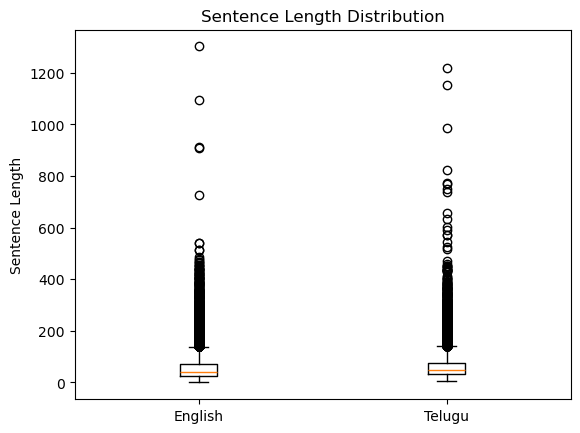

/var/folders/yb/r3k6h0y11431_5th45hwjmjr0000gn/T/ipykernel_1689/4225657690.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([english_hindi_lengths, sample_hindi_lengths], labels=['English', 'Hindi'])


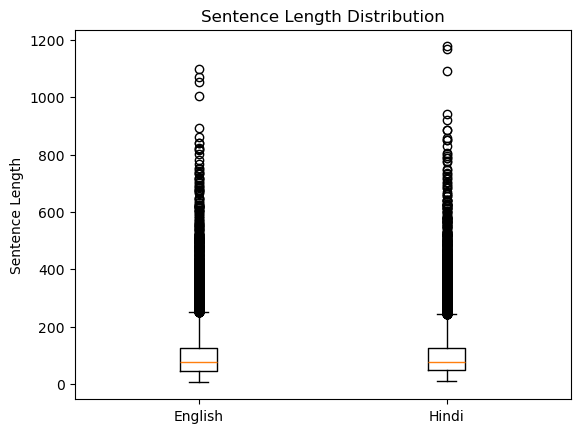

In [31]:
import matplotlib.pyplot as plt

# Calculate sentence lengths
english_telugu_lengths = [len(sentence) for sentence in source_eng_tel_trans]
sample_telugu_lengths = [len(sentence) for sentence in target_sample_telugu_sentences]

# Plot boxplots
plt.boxplot([english_telugu_lengths, sample_telugu_lengths], labels=['English', 'Telugu'])
plt.ylabel('Sentence Length')
plt.title('Sentence Length Distribution')
plt.show()

# Calculate sentence lengths
english_hindi_lengths = [len(sentence) for sentence in source_eng_hin_trans]
sample_hindi_lengths = [len(sentence) for sentence in target_sample_hindi_sentences]

# Plot boxplots
plt.boxplot([english_hindi_lengths, sample_hindi_lengths], labels=['English', 'Hindi'])
plt.ylabel('Sentence Length')
plt.title('Sentence Length Distribution')
plt.show()

In [32]:
# restricting the max length sentences to be allowed to 97 percentile

# Calculate desired percentile
percentile = 97
en_te_value = np.percentile(english_telugu_lengths, percentile)
telugu_value = np.percentile(sample_telugu_lengths, percentile)
en_hi_value = np.percentile(english_hindi_lengths, percentile)
hindi_value = np.percentile(sample_hindi_lengths, percentile)


print(f"{percentile}% of English sentences in English to Telugu dataset have length of {en_te_value} tokens or less")
print(f"{percentile}% of Telugu sentences in English to Telugu dataset have length of {telugu_value} tokens or less")
print(f"{percentile}% of English sentences in English to Hindi dataset have length of {en_hi_value} tokens or less")
print(f"{percentile}% of Hindi sentences in English to Hindi dataset have length of {hindi_value} tokens or less")

97% of English sentences in English to Telugu dataset have length of 176.0 tokens or less
97% of Telugu sentences in English to Telugu dataset have length of 171.0 tokens or less
97% of English sentences in English to Hindi dataset have length of 266.0 tokens or less
97% of Hindi sentences in English to Hindi dataset have length of 264.0 tokens or less


In [33]:
# passing sentences only if they have length less then the max sequence length
def is_valid_length(sentence, max_seq_length):
    return len(list(sentence)) < (max_seq_length - 1)

In [34]:
len(source_eng_tel_trans), len(target_sample_telugu_sentences), len(source_eng_hin_trans), len(target_sample_hindi_sentences)

(42000, 42000, 42000, 42000)

In [35]:
valid_english_telugu_sentence_indices = []

for index in range(len(target_sample_telugu_sentences)):
    valid_sample_eng_tel_sentences, valid_sample_telugu = source_eng_tel_trans[index], target_sample_telugu_sentences[index]
    if is_valid_length(valid_sample_eng_tel_sentences, max_seq_length)\
    and is_valid_length(valid_sample_telugu, max_seq_length):
        valid_english_telugu_sentence_indices.append(index)

In [36]:
valid_english_hindi_sentence_indices = []

for index in range(len(target_sample_hindi_sentences)):
    valid_sample_eng_hin_sentences, valid_sample_hindi = source_eng_hin_trans[index], target_sample_hindi_sentences[index]
    if is_valid_length(valid_sample_eng_hin_sentences, max_seq_length)\
    and is_valid_length(valid_sample_hindi, max_seq_length):
        valid_english_hindi_sentence_indices.append(index)

In [37]:
len(valid_english_telugu_sentence_indices), len(valid_english_hindi_sentence_indices)

(41790, 40866)

In [38]:
sample_valid_telugu_sentences = [target_sample_telugu_sentences[i] for i in valid_english_telugu_sentence_indices]
sample_valid_hindi_sentences = [target_sample_hindi_sentences[i] for i in valid_english_hindi_sentence_indices]
sample_valid_english_eng_hin_sentences = [source_eng_hin_trans[i] for i in valid_english_hindi_sentence_indices]
sample_valid_english_eng_tel_sentences = [source_eng_tel_trans[i] for i in valid_english_telugu_sentence_indices]

len(sample_valid_telugu_sentences), len(sample_valid_hindi_sentences), len(sample_valid_english_eng_hin_sentences), len(sample_valid_english_eng_tel_sentences)

(41790, 40866, 40866, 41790)

In [39]:
sample_valid_telugu_sentences[-2], sample_valid_english_eng_tel_sentences[-2]

('<_te_>అన్ని ప్రజలు తర్వాత ఎప్పుడైనా సంతోషంగా నివసిస్తున్నట్లు.',
 'Everyone lives happily ever after. ')

In [40]:
sample_valid_hindi_sentences[-2], sample_valid_english_eng_hin_sentences[-2]

('<_hi_>तब भी संकल्पनाओं के साम्राज्य में इससे आशातीत सामंजस्य प्रकट होता है।',
 'It may nevertheless unfold unsuspected harmonics in the realm of concept.')

In [41]:
# # appending <eos> at the end to the decoder inputs.
# eos_token = "<eos>"

# sample_valid_telugu_sentences = [sentence + " " + eos_token for sentence in sample_valid_telugu_sentences]
# sample_valid_hindi_sentences = [sentence + " " + eos_token for sentence in sample_valid_hindi_sentences]

# sample_valid_hindi_sentences[-2], sample_valid_telugu_sentences[-2]

### Preprocess Sentences into Tokens Using Bert Tokenizer

In [42]:
# Using Bert Tokenizer

from transformers import BertTokenizer

In [43]:
special_tokens = ["<_hi_>", "<_te_>"]

In [44]:
# load the pretrained bert tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

In [45]:
# tokenizer.eos_token = "<eos>"

In [46]:
tokenizer.vocab_size

119547

In [47]:
tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})

2

In [48]:
print("Special tokens added:", tokenizer.additional_special_tokens)
print("Vocabulary size:", tokenizer.vocab_size)

Special tokens added: ['<_hi_>', '<_te_>']
Vocabulary size: 119547


In [49]:
#tokenizer.vocab_size += len(tokenizer.additional_special_tokens)

In [50]:
total_vocab_size = tokenizer.vocab_size + len(tokenizer.additional_special_tokens)
total_vocab_size

119549

In [51]:
tokenizer.convert_tokens_to_ids(['<_hi_>'])

[119547]

In [52]:
tokenizer.convert_tokens_to_ids(['<_te_>'])

[119548]

In [53]:
tokenizer.eos_token_id

In [54]:
tokenizer.sep_token_id

102

In [85]:
tokenizer.vocab_size

119547

In [55]:
# Tokenizing source and target languages

tokenized_english_tel = tokenizer(
    sample_valid_english_eng_tel_sentences,
    padding = "max_length",
    truncation = True,
    max_length = max_seq_length,
    return_tensors = "pt"
)

tokenized_english_hin = tokenizer(
    sample_valid_english_eng_hin_sentences,
    padding = "max_length",
    truncation = True,
    max_length = max_seq_length,
    return_tensors = "pt"
)

In [56]:
# Tokenizing target telugu and hindi sentences

tokenized_telugu = tokenizer(
    sample_valid_telugu_sentences,
    padding = "max_length",
    truncation = True,
    max_length = max_seq_length,
    return_tensors = "pt"
)

tokenized_hindi = tokenizer(
    sample_valid_hindi_sentences,
    padding = "max_length",
    truncation = True,
    max_length = max_seq_length,
    return_tensors = "pt"
)

In [57]:
print(sample_valid_english_eng_hin_sentences[0])
print(f"Tokenized sample English to Hindi Sentence: {tokenizer.decode(tokenized_hindi["input_ids"][0])}")

In reply, Pakistan got off to a solid start.
Tokenized sample English to Hindi Sentence: [CLS] <_hi_> जिसके जवाब में पाक ने अच्छी शुरुआत की थी. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [58]:
print(sample_valid_english_eng_tel_sentences[0])
print(f"Tokenized sample English to Telugu Sentence: {tokenizer.decode(tokenized_telugu["input_ids"][0])}")

Shri Tomar also expressed gratitude to Prime Minister Shri Narendra Modi for bringing in long-awaited agricultural reforms by announcing legal amendments and ordinances which will empower the farmers and help them in getting remunerative prices for their produce. 
Tokenized sample English to Telugu Sentence: [CLS] <_te_> దీర్ఘకాలికంగా ఎదురు చూస్తున్న వ్యవసాయ సంస్కరణలను తీసుకువచ్చిన ప్రధానమంత్రి నరేంద్ర మోదీకి కృతజ్ఞతలు తెలిపారు. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [59]:
sample_valid_telugu_sentences[0]

'<_te_>దీర్ఘకాలికంగా ఎదురు చూస్తున్న వ్యవసాయ సంస్కరణలను తీసుకువచ్చిన ప్రధానమంత్రి నరేంద్ర మోదీకి కృతజ్ఞతలు తెలిపారు.'

In [60]:
# Combining English and Hindi/Telugu Sentences
data = {
    "source": sample_valid_english_eng_hin_sentences + sample_valid_english_eng_tel_sentences,
    "target": sample_valid_hindi_sentences + sample_valid_telugu_sentences
}

<!-- ### Preprocess Data using SentencePiece Tokenizer -->

In [61]:
# def preprocess_sentences(sentences, sp, max_seq_length):

#     # Tokenize and pad sequences
#     tokenized_sentences = [sp.encode_as_ids(sentence) for sentence in sentences]
#     padded_sentences = [
#         ids[:max_seq_length] + [0] * (max_seq_length - len(ids)) # this pads the sentence to max_seq_length
#         if len(ids) < max_seq_length  else ids[:max_seq_length]
#         for ids in tokenized_sentences
#     ]
#     return torch.tensor(padded_sentences)
# # preprocess english to hindi dataset
# tokenized_english_hi = preprocess_sentences(sample_valid_english_eng_hin_sentences, sp= sp, max_seq_length= max_seq_length)
# tokenized_hindi = preprocess_sentences(sample_valid_hindi_sentences, sp, max_seq_length)

# # preprocess english to telugu dataset
# tokenized_english_te = preprocess_sentences(sample_valid_english_eng_tel_sentences, sp, max_seq_length)
# tokenized_telugu = preprocess_sentences(sample_valid_telugu_sentences, sp, max_seq_length)
# # Now we combine the english sentences from source english to hindi and source english to telugu sentences and target sentences differently
# combined_english = {
#     "input_ids": torch.cat((tokenized_english_hi, tokenized_english_te)),
#     "attention_mask": torch.cat((torch.ones_like(tokenized_english_hi), torch.ones_like(tokenized_english_te)))
# }

# combined_target = {
#     "input_ids": torch.cat((tokenized_hindi, tokenized_telugu)),
#     "attention_mask": torch.cat((torch.ones_like(tokenized_hindi), torch.ones_like(tokenized_telugu)))
# }
# hi_token_ids = sp.encode_as_ids("_<hi> ")
# te_token_ids = sp.encode_as_ids("_<te> ")

# print(f"Token ID for _<hi> : {hi_token_ids}")
# print(f"Token ID for _<te> : {te_token_ids}")
# hi_decoded = sp.decode_ids(hi_token_ids)
# te_decoded = sp.decode_ids(te_token_ids)

# print(f"Decoded text for _<hi> : {hi_decoded}")
# print(f"Decoded text for _<te> : {te_decoded}")
# tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert", use_fast=True)
# print("Updated Vocabulary Size:", tokenizer.vocab_size)
# # defining special tokens for language specific sentences before we actually tokenize the whole sentences
# language_specific_tokens = {"hi":"<hi>", "te":"<te>"}

# print(list(language_specific_tokens.values()))
# # adding special tokens explicitly to the tokenizer - 
# tokenizer.add_special_tokens({"additional_special_tokens": list(language_specific_tokens.values())})
# print(tokenizer.vocab_size)
# print(list[language_specific_tokens.values()])
# lang_token_ids = {tokenizer.convert_tokens_to_ids(token) for token in language_specific_tokens.values()}
# print("Special Token IDs:", lang_token_ids)
# text = "This is a <hi> Hindi sentence. <te> Telugu sentence."
# tokenized_text = tokenizer(text)
# print(tokenized_text.input_ids)
# tokenizer.vocab_size
# # Check if special tokens are in the tokenizer
# print(f"<hi> ID: {tokenizer.convert_tokens_to_ids('<hi>')}")
# print(f"<te> ID: {tokenizer.convert_tokens_to_ids('<te>')}")
# print(f"Special tokens map: {tokenizer.special_tokens_map}")
# print(f"All special tokens: {tokenizer.all_special_tokens}")
# # English-to-Hindi dataset
# tokenized_english_en_hi_sentence = tokenizer(sample_valid_english_eng_hin_sentences, 
#                                              padding= "max_length", 
#                                              truncation= True, 
#                                              max_length= max_seq_length, 
#                                              return_tensors= "pt")

# tokenized_hindi_sentence = tokenizer(sample_valid_hindi_sentences, 
#                                      padding= "max_length", 
#                                      truncation= True, 
#                                      max_length= max_seq_length, 
#                                      return_tensors= "pt")
# # English to Telugu Dataset
# tokenized_english_en_te_sentence = tokenizer(sample_valid_english_eng_tel_sentences, 
#                                              padding= "max_length", 
#                                              truncation= True, 
#                                              max_length= max_seq_length, 
#                                              return_tensors= "pt")

# tokenized_telugu_sentence = tokenizer(sample_valid_telugu_sentences, 
#                                       padding= "max_length", 
#                                       truncation= True, 
#                                       max_length= max_seq_length, 
#                                       return_tensors="pt")
# tokenized_english_en_hi_sentence.keys()
# # Verify that the special tokens are added
# lang_token_ids = {lang: tokenizer.convert_tokens_to_ids(token) for lang, token in language_specific_tokens.items()}
# print("Language Token IDs:", lang_token_ids)  # Ensure unique IDs for `<hi>` and `<te>`
# # Tokenize a sample sentence with a prepended token
# sample_sentence = "<hi> This is a test sentence for Hindi."
# sample_tokenized = tokenizer(sample_sentence, return_tensors="pt", padding="max_length", truncation=True, max_length=max_seq_length)

# # Inspect input IDs
# print("Tokenized Input IDs:", sample_tokenized["input_ids"])
# print("Special Token ID for <hi>:", lang_token_ids["hi"])
# lang_token_ids["te"]
# sample_te_sentence = "<te> ఇది తెలుగులో పరీక్ష వాక్యం."
# tokenized_te = tokenizer(sample_te_sentence, return_tensors="pt", padding="max_length", truncation=True, max_length=max_seq_length)
# print("Special Token ID for <te>:", lang_token_ids["te"])
# assert lang_token_ids["te"] in tokenized_te["input_ids"]
# print("Vocabulary size:", tokenizer.vocab_size)
# # combined datasets
# combined_english = {
#     "input_ids": torch.cat((tokenized_english_en_hi_sentence["input_ids"], tokenized_english_en_te_sentence["input_ids"])),
#     "attention_mask": torch.cat((tokenized_english_en_hi_sentence["attention_mask"], tokenized_english_en_te_sentence["attention_mask"]))
# }

# combined_target = {
#     "input_ids": torch.cat((tokenized_hindi_sentence["input_ids"], tokenized_telugu_sentence["input_ids"])),
#     "attention_mask": torch.cat((tokenized_hindi_sentence["attention_mask"], tokenized_telugu_sentence["attention_mask"]))
# }
# combined_english
# # checking shapes
# print("Encoder input shape:", combined_english["input_ids"].shape)
# print("Decoder input shape:", combined_target["input_ids"].shape)
# # Combined lists of source english and target hindi and telugu language sentences into single list to pass into custom dataset

# # combined source english
# combined_source_english_sentences = sample_valid_english_eng_hin_sentences + sample_valid_english_eng_tel_sentences
# combined_target_sentences = sample_valid_hindi_sentences + sample_valid_telugu_sentences

# # create data dictionary

# data = {
#     "source": combined_source_english_sentences,
#     "target": combined_target_sentences
# }
# print("Language Token IDs:", lang_token_ids)
# print("Sample tokenized input IDs:", sample_tokenized["input_ids"])
# assert lang_token_ids["hi"] in sample_tokenized["input_ids"]
# print("Updated Vocabulary Size:", tokenizer.vocab_size)
# for token in language_specific_tokens.values():
#     assert token in tokenizer.get_vocab(), f"Token {token} not found in vocabulary!"
# print("Total source english sentences", len(data["source"]))
# print("Total target hindi and telugu sentences", len(data["target"]))
# for i in range(3):
#     print(f"Source Sentence {data["source"][i]}")
#     print(f"target sentence {data["target"][i]}")
#     print("*********")
# for i in range(-4,-1):
#     print(f"Source Sentence {data["source"][i]}")
#     print(f"target sentence {data["target"][i]}")
#     print("*********")

In [62]:
NEG_INFTY = 1e-9

In [63]:
from torch.utils.data import Dataset, DataLoader

class TranslationDataset(Dataset):
    def __init__(self, data, tokenizer, d_model, max_seq_length, pad_token_id, device):
        """
        Initializes the TranslationDataset by preparing encoder and decoder inputs with proper padding.
        """
        self.device = device  # Store device for later use

        # Prepare data using the tokenizer
        encoder_inputs = tokenizer(
            text=data["source"],
            padding="max_length",
            truncation=True,
            max_length=max_seq_length,
            return_tensors="pt"
        )
        decoder_inputs = tokenizer(
            text=data["target"],
            padding="max_length",
            truncation=True,
            max_length=max_seq_length,
            return_tensors="pt"
        )

        # Move tokenized data to device
        encoder_inputs = {k: v.to(device) for k, v in encoder_inputs.items()}
        decoder_inputs = {k: v.to(device) for k, v in decoder_inputs.items()}

        # Extract inputs and attention masks
        self.encoder_input_ids = encoder_inputs["input_ids"]
        self.encoder_attention_mask = encoder_inputs["attention_mask"]
        self.decoder_input_ids = decoder_inputs["input_ids"][:, :-1]  # Shift target by 1 for decoder
        self.decoder_attention_mask = decoder_inputs["attention_mask"][:, :-1]  # Match decoder sequence length

        self.max_seq_length_encoder = self.encoder_input_ids.size(1)  # Dynamic seq length for encoder
        self.max_seq_length_decoder = self.decoder_input_ids.size(1)  # Dynamic seq length for decoder
        self.tokenizer = tokenizer
        self.d_model = d_model
        self.pad_token_id = pad_token_id

        #print(f"The shape of Encoder input IDs: {self.encoder_input_ids.shape}")
        #print(f"The shape of Decoder input IDs: {self.decoder_input_ids.shape}")

        # Calculate sequence lengths from attention masks
        self.encoder_seq_len = self.encoder_attention_mask.sum(dim=1).tolist()
        self.decoder_seq_len = self.decoder_attention_mask.sum(dim=1).tolist()

        # Generate masks
        self.encoder_mask, self.decoder_self_attention_mask, self.cross_attention_mask = self.create_masks()

    def __len__(self):
        return self.encoder_input_ids.size(0)

    def __getitem__(self, idx):

        return {
            "encoder_input_ids": self.encoder_input_ids[idx],
            "encoder_attention_mask": self.encoder_attention_mask[idx],
            "decoder_input_ids": self.decoder_input_ids[idx],
            "decoder_attention_mask": self.decoder_attention_mask[idx],
            "cross_attention_mask": self.cross_attention_mask[idx]
        }

    def create_padding_mask(self, sequence_lengths, max_seq_len):
        """
        Creates padding masks for the input sequences.
        Padding positions are marked as False (0) for valid tokens and True (1) for padding.
        """
        batch_size = len(sequence_lengths)
        mask = torch.ones((batch_size, max_seq_len), dtype=torch.bool, device=self.device)

        for i, length in enumerate(sequence_lengths):
            mask[i, :length] = False  # Valid positions are False

        return mask

    def create_look_ahead_mask(self, seq_len):
        """Creates a look-ahead mask to block future tokens for autoregressive decoding."""
        return torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool, device=self.device), diagonal=1)

    def create_masks(self):
        """
        Generates all required masks: encoder padding mask, decoder self-attention mask, and cross-attention mask.
        """
        # Create padding masks
        initial_encoder_padding_mask = self.create_padding_mask(self.encoder_seq_len, self.max_seq_length_encoder)
        initial_decoder_padding_mask = self.create_padding_mask(self.decoder_seq_len, self.max_seq_length_decoder)
        #print("The encoder padding mask generated is of shape - ", initial_encoder_padding_mask.shape)
        #print("The decoder padding mask generated is of shape - ", initial_decoder_padding_mask.shape)

        # Expand encoder padding mask for multi-head attention
        encoder_mask = initial_encoder_padding_mask.unsqueeze(1).unsqueeze(2)  # Shape: (batch_size, 1, 1, encoder_seq_len)
        #print("The generated encoder mask is of shape - ", encoder_mask.shape)

        # Look-ahead mask for decoder
        initial_decoder_self_attention_mask = self.create_look_ahead_mask(self.max_seq_length_decoder)
        #print("The initial shape of decoder lookahead mask is - ", initial_decoder_self_attention_mask.shape)

        # Unsqueeze and expand decoder padding mask
        decoder_padding_mask = initial_decoder_padding_mask.unsqueeze(1).unsqueeze(2)  # Shape: (batch_size, 1, 1, decoder_seq_len)
        #print("Unsqueezed decoder padding mask shape is - ", decoder_padding_mask.shape)

        # Combine decoder padding mask with look-ahead mask for self-attention
        #print("The decoder self attention mask is of shape - ", initial_decoder_self_attention_mask.shape)
        decoder_self_attention_mask = initial_decoder_self_attention_mask.unsqueeze(0).unsqueeze(1)  # Shape: (1, 1, decoder_seq_len, decoder_seq_len)
        #print(f"After unsqueezing and adding dim at 0th and 1th position of decoder_self_attention_mask - {decoder_self_attention_mask.shape}")
        decoder_self_attention_mask = decoder_self_attention_mask | decoder_padding_mask  # Shape: (batch_size, 1, decoder_seq_len, decoder_seq_len)
        #print("The decoder self attention mask generated is of shape - ", decoder_self_attention_mask.shape)

        #print("Initial encoder padding mask used for cross attention mask", initial_encoder_padding_mask.shape)
        # Expand decoder padding mask for cross-attention
        
        # Correct Cross-Attention Mask: Use encoder padding mask for the cross-attention
        cross_attention_mask = initial_encoder_padding_mask.unsqueeze(1).unsqueeze(2)
        #print("Cross Attention mask generated unsqueezed is of shape - ",cross_attention_mask.shape)
        cross_attention_mask =  cross_attention_mask.expand(-1, -1, self.max_seq_length_decoder, self.max_seq_length_encoder)
        #print("The encoder decoder cross attention mask generated is of shape - ", cross_attention_mask.shape)

        #cross_attention_mask = initial_decoder_self_attention_mask.expand(-1, -1, self.max_seq_length_decoder, self.max_seq_length_encoder)
        #print("The encoder decoder cross attention mask generated is of shape - ", cross_attention_mask.shape)

        print("---- APPLYING NEG INF TO MASKS ----")

        # Apply negative infinity values for masked positions
        encoder_mask = encoder_mask.float().masked_fill(mask=encoder_mask, value=NEG_INFTY)
        #print("The shape of encoder mask after adding -neg infinity values to 0 positions", encoder_mask.shape)
        decoder_self_attention_mask = decoder_self_attention_mask.float().masked_fill(mask=decoder_self_attention_mask, value=NEG_INFTY)
        #print("The shape of decoder mask after adding -neg infinity values to 0 positions", decoder_self_attention_mask.shape)
        cross_attention_mask = cross_attention_mask.float().masked_fill(mask=cross_attention_mask, value=NEG_INFTY)
        #print("The shape of encoder decoder cross attention mask after adding -neg infinity values to 0 positions", cross_attention_mask.shape)


        print("---- AFTER APPLYING NEG INFINITY TO THE MASKS ----")

        #print(f"Encoder mask shape: {encoder_mask.shape}")
        #print(f"Decoder self-attention mask shape: {decoder_self_attention_mask.shape}")
        #print(f"Cross-attention mask shape: {cross_attention_mask.shape}")

        return encoder_mask, decoder_self_attention_mask, cross_attention_mask

In [64]:
# Initilization of dataset and dataloader

# Initialize Dataset
translation_dataset = TranslationDataset(
    data=data,
    tokenizer=tokenizer,
    d_model=d_model,
    max_seq_length=max_seq_length,
    pad_token_id=tokenizer.pad_token_id,
    device=device,
)

---- APPLYING NEG INF TO MASKS ----
---- AFTER APPLYING NEG INFINITY TO THE MASKS ----


In [65]:
# Initialize DataLoader
translation_dataloader = DataLoader(
    dataset=translation_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [66]:
# Verifying prepared data

for batch in translation_dataloader:
    print("Encoder Input IDs:", batch["encoder_input_ids"].shape)
    print("Decoder Input IDs:", batch["decoder_input_ids"].shape)
    print("Encoder Mask:", batch["encoder_attention_mask"].shape)
    print("Decoder Self-Attention Mask:", batch["decoder_attention_mask"].shape)
    print("Cross-Attention Mask:", batch["cross_attention_mask"].shape)
    break

Encoder Input IDs: torch.Size([16, 300])
Decoder Input IDs: torch.Size([16, 299])
Encoder Mask: torch.Size([16, 300])
Decoder Self-Attention Mask: torch.Size([16, 299])
Cross-Attention Mask: torch.Size([16, 1, 299, 300])


In [67]:
class TransformerModel(nn.Module):
    def __init__(self,
                 d_model,
                 vocab_size,
                 num_heads,
                 num_layers,
                 drop_prob,
                 max_seq_length,
                 encoder_positional_encoder,
                 decoder_positional_encoder,
                 device):
        super().__init__()
        
        self.device = device  # Store device
        
        # Embedding layers for encoder and decoder
        self.encoder_embedding = nn.Embedding(tokenizer.vocab_size, d_model).to(device)
        self.decoder_embedding = nn.Embedding(tokenizer.vocab_size, d_model).to(device)
        
        # Positional Encodings
        self.encoder_positional_encoder = encoder_positional_encoder.to(device)
        self.decoder_positional_encoder = decoder_positional_encoder.to(device)
        
        # Encoder and decoder layers
        self.encoder = EncoderBlock(
            d_model=d_model,
            ffn_hidden=ffn_hidden,
            num_heads=num_heads,
            drop_prob=drop_prob,
            num_layers=num_layers
        ).to(device)
        self.decoder = DecoderLayer(
            d_model=d_model,
            ffn_hidden=ffn_hidden,
            drop_prob=drop_prob,
            num_heads=num_heads
        ).to(device)
        
        # Output layer
        self.output_layer = nn.Linear(in_features=d_model, out_features=vocab_size).to(device)

    def forward(self, encoder_input_ids, encoder_attention_mask, decoder_input_ids, decoder_self_attention_mask, cross_attention_mask):
        # Move inputs to device
        encoder_input_ids = encoder_input_ids.to(self.device)
        encoder_attention_mask = encoder_attention_mask.to(self.device)
        decoder_input_ids = decoder_input_ids.to(self.device)
        decoder_self_attention_mask = decoder_self_attention_mask.to(self.device)
        cross_attention_mask = cross_attention_mask.to(self.device)
        
        # Apply embedding layers
        encoder_embeds = self.encoder_embedding(encoder_input_ids)  # Shape: (batch_size, seq_len, d_model)
        decoder_embeds = self.decoder_embedding(decoder_input_ids)  # Shape: (batch_size, seq_len, d_model)

        # Add positional encodings
        encoder_embeds += self.encoder_positional_encoder(encoder_embeds)
        decoder_embeds += self.decoder_positional_encoder(decoder_embeds)
        
        # Encoder and decoder
        #print("The encoder attention mask shape is  -", encoder_attention_mask.shape)
        encoder_output = self.encoder(encoder_embeds, encoder_attention_mask)
        #print(f"The Encoder Encoder output shape before passing to decoder: {encoder_output.shape}")
        #print(f"The shape of decoder embeds which enter the decoder layers is {decoder_embeds.shape}")
        #print(f"The decoder self attention mask shape is -", decoder_self_attention_mask.shape)
        #print(f"The encoder decoder cross attention mask shape is - ", cross_attention_mask.shape)

        decoder_output = self.decoder(encoder_output, decoder_embeds, decoder_self_attention_mask, cross_attention_mask)
        
        # Output logits
        logits = self.output_layer(decoder_output)
        return logits

In [68]:
encoder_positional_encoder = PositionEncoding(d_model, max_seq_length)
decoder_positional_encoder = PositionEncoding(d_model, max_seq_length)

In [69]:
transformer_model = TransformerModel(d_model=d_model,
                                     vocab_size= total_vocab_size,
                                     num_heads= num_heads,
                                     num_layers= num_layers,
                                     drop_prob= drop_prob,
                                     max_seq_length= max_seq_length,
                                     encoder_positional_encoder= encoder_positional_encoder,
                                     decoder_positional_encoder= decoder_positional_encoder,
                                     device=device)

In [70]:
transformer_model.encoder_embedding = nn.Embedding(total_vocab_size, d_model).to(device)
transformer_model.decoder_embedding = nn.Embedding(total_vocab_size, d_model).to(device)

In [71]:
for batch in translation_dataloader:
    print("Max Encoder Input ID:", batch["encoder_input_ids"].max().item())
    print("Max Decoder Input ID:", batch["decoder_input_ids"].max().item())
    break

Max Encoder Input ID: 110239
Max Decoder Input ID: 119548


In [72]:
tokenizer.eos_token_id

In [73]:
print(sample_valid_hindi_sentences[99])
tokenized_target = tokenizer(sample_valid_hindi_sentences[0], return_tensors="pt", add_special_tokens=True)
print(tokenized_target["input_ids"])

<_hi_>मंत्रालय ने कहा कि उड़े देश का आम नागरिक यानी उड़ान योजना के तहत अब तक कुल 766 मार्गों को मंजूरी दी गई है।
tensor([[   101, 119547,  61881,    872,  28960,  18351,  10532,    885,  11208,
          12151,  13088,    851,  16940,  33345,  10914, 110065,  10826,  15837,
            119,    102]])


In [74]:
total_vocab_size

119549

In [75]:
print("All Special Tokens:", tokenizer.all_special_tokens)

All Special Tokens: ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]', '<_hi_>', '<_te_>']


In [76]:
hi_id = tokenizer.convert_tokens_to_ids('<_hi_>')
te_id = tokenizer.convert_tokens_to_ids('<_te_>')

print(f"Tokenizer vocabulary for '<_hi_>': {tokenizer.convert_tokens_to_ids('<_hi_>')}")
print(f"Tokenizer vocabulary for '<hi>': {tokenizer.convert_tokens_to_ids('<hi>')}")
print(f"Tokenizer vocabulary for '<_te_>': {tokenizer.convert_tokens_to_ids('<_te_>')}")
print(f"Tokenizer vocabulary for '<te>': {tokenizer.convert_tokens_to_ids('<te>')}")

print(f"Token ID for <_hi_>: {hi_id}")
print(f"Token ID for <_te_>: {te_id}")
print(f"Total Vocabulary Size: {total_vocab_size}")

assert hi_id < total_vocab_size, "Token ID for <_hi_> exceeds total vocab size!"
assert te_id < total_vocab_size, "Token ID for <_te_> exceeds total vocab size!"

Tokenizer vocabulary for '<_hi_>': 119547
Tokenizer vocabulary for '<hi>': 100
Tokenizer vocabulary for '<_te_>': 119548
Tokenizer vocabulary for '<te>': 100
Token ID for <_hi_>: 119547
Token ID for <_te_>: 119548
Total Vocabulary Size: 119549


In [77]:
for batch in translation_dataloader:
    print("Sample decoder input IDs:")
    print(batch["decoder_input_ids"][0])  # First sentence in the batch
    decoded_tokens = tokenizer.convert_ids_to_tokens(batch["decoder_input_ids"][0].tolist())
    print("Decoded tokens:")
    print(decoded_tokens)
    break

Sample decoder input IDs:
tensor([   101, 119548,   1234,  34479,  41772,  91124,  80466,   1224,  93137,
         13179, 107828,   1220,  26056,  15280,  30805,    113,   1207,  15868,
           119,   1234,  37637,  56585,    119,   1195,  13652,    119,  97558,
           119,    114,   1234,  34479,  41772,  91124,  80466,    117,  97558,
         17456, 108696,  52798,  15735,  80466,  55150,   1220,  52798,  87978,
         13302,  46832,  14314,   1215,  18564,  15695, 111330,  52640,  15280,
         21120,  61924,  13652,   1196,  15695,  48317,  83507,  30805,    119,
           102,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0

In [78]:
for batch in translation_dataloader:
    logits = transformer_model(
        encoder_input_ids=batch["encoder_input_ids"],
        encoder_attention_mask=batch["encoder_attention_mask"],
        decoder_input_ids=batch["decoder_input_ids"],
        decoder_self_attention_mask=batch["decoder_attention_mask"],
        cross_attention_mask=batch["cross_attention_mask"])
    print("Logits Shape is -", logits.shape)
    break

Logits Shape is - torch.Size([16, 299, 119549])


In [79]:
hi_id = tokenizer.convert_tokens_to_ids("<_hi_>")
te_id = tokenizer.convert_tokens_to_ids("<_te_>")
hi_id, te_id

(119547, 119548)

In [80]:
# defining the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.Adam(params=transformer_model.parameters(), lr= learning_rate)

In [81]:
# def train_model(model, dataloader, num_epochs, learning_rate, tokenizer, pad_token_id, device):
#     """
#     Function to train the Transformer model for multilingual translation.
#     Args:
#         model (nn.Module): The Transformer model.
#         dataloader (DataLoader): The DataLoader providing the training data.
#         num_epochs (int): Number of training epochs.
#         learning_rate (float): Learning rate for the optimizer.
#         tokenizer (AutoTokenizer): Tokenizer for text processing.
#         pad_token_id (int): Padding token ID for calculating loss.
#         device (str): Device for training ('cuda' or 'cpu').
#     Returns:
#         model (nn.Module): The trained model.
#         metrics (dict): Training metrics, including epoch and batch losses.
#     """
#     # Move model to device
#     model.to(device)
#     metrics = {"epoch_losses": [], 
#                "batch_loss": [],
#                "language_specific_loss": {"hindi": [], "telugu": []}}
#     print(f"Hindi Identifeir Token Id: {hi_id}, Telugu Identifier Token Id: {te_id}")
    
#     # Training loop
#     model.train()
#     for epoch in range(num_epochs):
#         epoch_loss = 0.0
#         print(f"Epoch {epoch + 1}/{num_epochs}")

#         for batch_idx, batch in enumerate(tqdm(dataloader, desc="Training")):
#             # Move batch data to device
#             encoder_input_ids = batch["encoder_input_ids"].to(device)
#             encoder_attention_mask = batch["encoder_attention_mask"].to(device)
#             decoder_input_ids = batch["decoder_input_ids"].to(device)
#             decoder_attention_mask = batch["decoder_attention_mask"].to(device)
#             cross_attention_mask = batch["cross_attention_mask"].to(device)

#             # Prepare decoder target by shifting left
#             target_ids = torch.cat([
#                 decoder_input_ids[:, 1:], 
#                 torch.full((decoder_input_ids.size(0), 1), pad_token_id, dtype=torch.long, device=device)
#             ], dim=1)  # Right-pad to match the shifted sequence

#             # Debug: Count Hindi and Telugu sentences in the batch
#             hi_count = (decoder_input_ids[:, 1] == hi_id).sum().item()
#             te_count = (decoder_input_ids[:, 1] == te_id).sum().item()
#             print(f"Batch {batch_idx + 1}: Hindi: {hi_count}, Telugu: {te_count}")

#             # Forward pass
#             logits = model(
#                 encoder_input_ids=encoder_input_ids,
#                 encoder_attention_mask=encoder_attention_mask,
#                 decoder_input_ids=decoder_input_ids,
#                 decoder_self_attention_mask=decoder_attention_mask,
#                 cross_attention_mask=cross_attention_mask
#             )

#             # Reshape logits and target for loss calculation
#             logits = logits.view(-1, logits.size(-1))  # Shape: (batch_size * seq_len, vocab_size)
#             target_ids = target_ids.view(-1)  # Shape: (batch_size * seq_len)

#             # Calculate loss
#             loss = criterion(logits, target_ids)

#             # Backpropagation and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             # Log batch loss
#             metrics["batch_loss"].append(loss.item())

#             # Accumulate epoch loss
#             epoch_loss += loss.item()

#             # Language Specific Loss
#             batch_hi_loss = []
#             batch_te_loss = []

#             # Language Specific Loss - 
#             for i in range(decoder_input_ids.size(0)):
#                 if decoder_input_ids[i, 1].item() == hi_id:
#                     #metrics["language_specific_loss"]["hindi"].append(loss.item())
#                     batch_hi_loss.append(loss.item())
#                 elif decoder_input_ids[i, 1].item() == te_id:
#                     #metrics["language_specific_loss"]["telugu"].append(loss.item())
#                     batch_te_loss.append(loss.item())


#             avg_batch_hi_loss = sum(batch_hi_loss) / len(batch_hi_loss) if batch_hi_loss else 0
#             avg_batch_te_loss = sum(batch_te_loss) / len(batch_te_loss) if batch_te_loss else 0

#             # Print batch metrics
#             print(f"Batch {batch_idx + 1} Loss: {loss.item():.4f}")
#             print(f"Batch {batch_idx + 1} Average Hindi Language Loss: {avg_batch_hi_loss:.4f}")
#             print(f"Batch {batch_idx + 1} Average Telugu Language Loss: {avg_batch_te_loss:.4f}")

#         # Compute average epoch loss
#         average_epoch_loss = epoch_loss / len(dataloader)
#         metrics["epoch_losses"].append(average_epoch_loss)

#         # Average language specific loss - 
#         avg_hi_loss = sum(metrics["language_specific_loss"]["hindi"]) / len(metrics["language_specific_loss"]["hindi"]) if metrics["language_specific_loss"]["hindi"] else 0
#         avg_te_loss = sum(metrics["language_specific_loss"]["telugu"]) / len(metrics["language_specific_loss"]["telugu"]) if metrics["language_specific_loss"]["telugu"] else 0
        
#         # Print epoch loss
#         print(f"Epoch {epoch + 1} Loss: {average_epoch_loss:.4f}")
#         print(f"Epoch {epoch + 1} Average Hindi Language Loss: {avg_hi_loss:.4f}")
#         print(f"Epoch {epoch + 1} Average Telugu Language Loss: {avg_te_loss:.4f}")

#     print("Training complete.")
#     return model, metrics

In [82]:
# def train_model(model, dataloader, num_epochs, learning_rate, tokenizer, pad_token_id, device):
#     """
#     Function to train the Transformer model for multilingual translation.
#     """
#     # Move model to device
#     model.to(device)
#     metrics = {"epoch_losses": [], 
#                "batch_loss": [],
#                "language_specific_loss": {"hindi": [], "telugu": []}}
    
#     # Debug IDs
#     hi_id = tokenizer.convert_tokens_to_ids("<_hi_>")
#     te_id = tokenizer.convert_tokens_to_ids("<_te_>")
#     print(f"Hindi ID: {hi_id}, Telugu ID: {te_id}")

#     # Training loop
#     model.train()
#     for epoch in range(num_epochs):
#         epoch_loss = 0.0
#         print(f"\nEpoch {epoch + 1}/{num_epochs}")

#         for batch_idx, batch in enumerate(tqdm(dataloader, desc="Training")):
#             # Move batch data to device
#             encoder_input_ids = batch["encoder_input_ids"].to(device)
#             encoder_attention_mask = batch["encoder_attention_mask"].to(device)
#             decoder_input_ids = batch["decoder_input_ids"].to(device)
#             decoder_attention_mask = batch["decoder_attention_mask"].to(device)
#             cross_attention_mask = batch["cross_attention_mask"].to(device)

#             # Prepare decoder target by shifting left
#             target_ids = torch.cat([
#                 decoder_input_ids[:, 1:], 
#                 torch.full((decoder_input_ids.size(0), 1), pad_token_id, dtype=torch.long, device=device)
#             ], dim=1)  # Right-pad to match the shifted sequence

#             # Debug: Count Hindi and Telugu sentences in the batch
#             hi_count = (decoder_input_ids[:, 0] == hi_id).sum().item()
#             te_count = (decoder_input_ids[:, 0] == te_id).sum().item()
#             print(f"Batch {batch_idx + 1}: Hindi: {hi_count}, Telugu: {te_count}")

#             # Forward pass
#             logits = model(
#                 encoder_input_ids=encoder_input_ids,
#                 encoder_attention_mask=encoder_attention_mask,
#                 decoder_input_ids=decoder_input_ids,
#                 decoder_self_attention_mask=decoder_attention_mask,
#                 cross_attention_mask=cross_attention_mask
#             )

#             # Reshape logits and target for loss calculation
#             logits = logits.view(-1, logits.size(-1))  # Shape: (batch_size * seq_len, vocab_size)
#             target_ids = target_ids.view(-1)  # Shape: (batch_size * seq_len)

#             # Calculate loss
#             loss = criterion(logits, target_ids)

#             # Backpropagation and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             # Log batch loss
#             metrics["batch_loss"].append(loss.item())

#             # Accumulate epoch loss
#             epoch_loss += loss.item()

#             # Language-Specific Loss Tracking
#             for i in range(decoder_input_ids.size(0)):
#                 if decoder_input_ids[i, 0].item() == hi_id:
#                     metrics["language_specific_loss"]["hindi"].append(loss.item())
#                 elif decoder_input_ids[i, 0].item() == te_id:
#                     metrics["language_specific_loss"]["telugu"].append(loss.item())

#         # Compute average epoch loss
#         average_epoch_loss = epoch_loss / len(dataloader)
#         metrics["epoch_losses"].append(average_epoch_loss)

#         # Average language-specific loss
#         avg_hi_loss = (
#             sum(metrics["language_specific_loss"]["hindi"]) /
#             len(metrics["language_specific_loss"]["hindi"]) 
#             if metrics["language_specific_loss"]["hindi"] else 0
#         )
#         avg_te_loss = (
#             sum(metrics["language_specific_loss"]["telugu"]) /
#             len(metrics["language_specific_loss"]["telugu"]) 
#             if metrics["language_specific_loss"]["telugu"] else 0
#         )

#         # Print epoch loss
#         print(f"Epoch {epoch + 1} Loss: {average_epoch_loss:.4f}")
#         print(f"Epoch {epoch + 1} Average Hindi Language Loss: {avg_hi_loss:.4f}")
#         print(f"Epoch {epoch + 1} Average Telugu Language Loss: {avg_te_loss:.4f}")

#     print("Training complete.")
#     return model, metrics

In [83]:
def train_model(model, dataloader, num_epochs, learning_rate, tokenizer, pad_token_id, device):
    """ Function to train the Transformer model for multilingual translation.

    Args:
        model (nn.Module): The Transformer model.
        dataloader (DataLoader): The DataLoader providing the training data.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
        tokenizer (AutoTokenizer): Tokenizer for text processing.
        pad_token_id (int): Padding token ID for calculating loss.
        device (str): Device for training ('cuda' or 'cpu').

    Returns:
        model (nn.Module): The trained model.
        metrics (dict): Training metrics, including epoch and batch losses.
    """

    model.to(device)
    metrics = {"epoch_losses": [], "batch_loss": [], "language_specific_loss": {"hindi": [], "telugu": []}}

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        print(f"Epoch {epoch + 1}/{num_epochs}")
        batch_losses = []  # Track batch losses for this epoch

        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Training")):
            # Move batch data to device
            encoder_input_ids = batch["encoder_input_ids"].to(device)
            encoder_attention_mask = batch["encoder_attention_mask"].to(device)
            decoder_input_ids = batch["decoder_input_ids"].to(device)
            decoder_attention_mask = batch["decoder_attention_mask"].to(device)
            cross_attention_mask = batch["cross_attention_mask"].to(device)

            # Prepare decoder target by shifting left
            target_ids = torch.cat([decoder_input_ids[:, 1:], torch.full((decoder_input_ids.size(0), 1), pad_token_id, dtype=torch.long, device=device)], dim=1)

            # Forward pass
            logits = model(
                encoder_input_ids=encoder_input_ids,
                encoder_attention_mask=encoder_attention_mask,
                decoder_input_ids=decoder_input_ids,
                decoder_self_attention_mask=decoder_attention_mask,
                cross_attention_mask=cross_attention_mask,
            )

            # Reshape logits and target for loss calculation
            logits = logits.view(-1, logits.size(-1))
            target_ids = target_ids.view(-1)

            # Calculate loss
            loss = criterion(logits, target_ids)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Log batch loss
            metrics["batch_loss"].append(loss.item())
            batch_losses.append(loss.item())

            # Print every 400 batches
            if (batch_idx + 1) % 400 == 0:
                hi_count = (decoder_input_ids[:, 1] == hi_id).sum().item()
                te_count = (decoder_input_ids[:, 1] == te_id).sum().item()
                print(f"Batch {batch_idx + 1}: Hindi: {hi_count}, Telugu: {te_count}")

        # Accumulate epoch loss
        epoch_loss = sum(batch_losses)

        # Language Specific Loss
        language_specific_batch_losses = {"hindi": [], "telugu": []}
        for i in range(decoder_input_ids.size(0)):
            if decoder_input_ids[i, 1].item() == hi_id:
                language_specific_batch_losses["hindi"].append(loss.item())
            elif decoder_input_ids[i, 1].item() == te_id:
                language_specific_batch_losses["telugu"].append(loss.item())

        # Calculate average epoch loss and language specific losses
        average_epoch_loss = epoch_loss / len(dataloader)
        avg_hi_loss = sum(language_specific_batch_losses["hindi"]) / len(language_specific_batch_losses["hindi"]) if language_specific_batch_losses["hindi"] else 0
        avg_te_loss = sum(language_specific_batch_losses["telugu"]) / len(language_specific_batch_losses["telugu"]) if language_specific_batch_losses["telugu"] else 0

        # Print epoch loss and language-specific losses
        print(f"Epoch {epoch + 1} Loss: {average_epoch_loss:.4f}")
        print(f"Epoch {epoch + 1} Average Hindi Language Loss: {avg_hi_loss:.4f}")
        print(f"Epoch {epoch + 1} Average Telugu Language Loss: {avg_te_loss:.4f}")
        print(f"Epoch {epoch + 1} Average Batch Loss: {sum(batch_losses) / len(batch_losses):.4f}")

        # Log epoch loss and language-specific losses to metrics
        metrics["epoch_losses"].append(average_epoch_loss)
        metrics["language_specific_loss"]["hindi"].append(avg_hi_loss)
        metrics["language_specific_loss"]["telugu"].append(avg_te_loss)

    print("Training complete.")
    return model, metrics

In [89]:
trained_model, training_metrics = train_model(
    model=transformer_model,
    dataloader=translation_dataloader,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    tokenizer=tokenizer,
    pad_token_id=tokenizer.pad_token_id,
    device=device
)

Epoch 1/8


Training:   8%|▊         | 400/5166 [42:58<5:57:00,  4.49s/it]   

Batch 400: Hindi: 9, Telugu: 7


Training:  15%|█▌        | 800/5166 [1:11:03<5:08:17,  4.24s/it]

Batch 800: Hindi: 6, Telugu: 10


Training:  23%|██▎       | 1200/5166 [1:38:16<4:25:28,  4.02s/it]

Batch 1200: Hindi: 5, Telugu: 11


Training:  31%|███       | 1600/5166 [2:04:58<4:07:27,  4.16s/it]

Batch 1600: Hindi: 6, Telugu: 10


Training:  39%|███▊      | 2000/5166 [2:32:56<3:17:41,  3.75s/it] 

Batch 2000: Hindi: 10, Telugu: 6


Training:  46%|████▋     | 2400/5166 [2:59:23<3:02:05,  3.95s/it]

Batch 2400: Hindi: 9, Telugu: 7


Training:  54%|█████▍    | 2800/5166 [3:24:56<2:24:26,  3.66s/it]

Batch 2800: Hindi: 3, Telugu: 13


Training:  62%|██████▏   | 3200/5166 [4:05:50<2:17:37,  4.20s/it]   

Batch 3200: Hindi: 7, Telugu: 9


Training:  70%|██████▉   | 3600/5166 [7:59:12<5:13:54, 12.03s/it]   

Batch 3600: Hindi: 5, Telugu: 11


Training:  77%|███████▋  | 4000/5166 [11:19:15<1:21:51,  4.21s/it]   

Batch 4000: Hindi: 7, Telugu: 9


Training:  85%|████████▌ | 4400/5166 [12:18:36<51:06,  4.00s/it]    

Batch 4400: Hindi: 7, Telugu: 9


Training:  93%|█████████▎| 4800/5166 [12:44:53<26:31,  4.35s/it]

Batch 4800: Hindi: 10, Telugu: 6


Training: 100%|██████████| 5166/5166 [13:10:03<00:00,  9.18s/it]


Epoch 1 Loss: 2.3876
Epoch 1 Average Hindi Language Loss: 1.2992
Epoch 1 Average Telugu Language Loss: 1.2992
Epoch 1 Average Batch Loss: 2.3876
Epoch 2/8


Training:   8%|▊         | 400/5166 [26:25<5:21:14,  4.04s/it]

Batch 400: Hindi: 6, Telugu: 10


Training:  15%|█▌        | 800/5166 [1:45:39<4:37:48,  3.82s/it]   

Batch 800: Hindi: 10, Telugu: 6


Training:  23%|██▎       | 1200/5166 [2:18:43<5:54:36,  5.36s/it]

Batch 1200: Hindi: 7, Telugu: 9


Training:  31%|███       | 1600/5166 [3:43:39<39:29:40, 39.87s/it]  

Batch 1600: Hindi: 5, Telugu: 11


Training:  39%|███▊      | 2000/5166 [7:58:15<3:11:23,  3.63s/it]   

Batch 2000: Hindi: 9, Telugu: 7


Training:  46%|████▋     | 2400/5166 [8:27:07<3:20:41,  4.35s/it]

Batch 2400: Hindi: 10, Telugu: 6


Training:  54%|█████▍    | 2800/5166 [9:20:03<3:25:54,  5.22s/it]   

Batch 2800: Hindi: 9, Telugu: 7


Training:  62%|██████▏   | 3200/5166 [10:36:54<2:13:07,  4.06s/it]   

Batch 3200: Hindi: 6, Telugu: 10


Training:  70%|██████▉   | 3600/5166 [11:22:22<13:06:17, 30.13s/it] 

Batch 3600: Hindi: 9, Telugu: 7


Training:  77%|███████▋  | 4000/5166 [13:41:18<6:14:23, 19.27s/it]   

Batch 4000: Hindi: 8, Telugu: 8


Training:  85%|████████▌ | 4400/5166 [19:40:26<8:49:19, 41.46s/it]  

Batch 4400: Hindi: 9, Telugu: 7


Training:  93%|█████████▎| 4800/5166 [22:56:36<24:14,  3.97s/it]    

Batch 4800: Hindi: 10, Telugu: 6


Training: 100%|██████████| 5166/5166 [24:41:14<00:00, 17.20s/it]    


Epoch 2 Loss: 0.4358
Epoch 2 Average Hindi Language Loss: 0.2723
Epoch 2 Average Telugu Language Loss: 0.2723
Epoch 2 Average Batch Loss: 0.4358
Epoch 3/8


Training:   8%|▊         | 400/5166 [1:03:39<4:49:50,  3.65s/it]

Batch 400: Hindi: 8, Telugu: 8


Training:  15%|█▌        | 800/5166 [3:17:05<16:51:59, 13.91s/it]  

Batch 800: Hindi: 10, Telugu: 6


Training:  23%|██▎       | 1200/5166 [8:05:17<324:35:46, 294.64s/it]

Batch 1200: Hindi: 9, Telugu: 7


Training:  31%|███       | 1600/5166 [13:15:59<42:00:44, 42.41s/it]  

Batch 1600: Hindi: 8, Telugu: 8


Training:  39%|███▊      | 2000/5166 [22:49:50<3:23:58,  3.87s/it]   

Batch 2000: Hindi: 6, Telugu: 10


Training:  46%|████▋     | 2400/5166 [24:47:22<6:11:46,  8.06s/it]   

Batch 2400: Hindi: 8, Telugu: 8


Training:  54%|█████▍    | 2800/5166 [25:51:02<2:23:41,  3.64s/it]   

Batch 2800: Hindi: 11, Telugu: 5


Training:  62%|██████▏   | 3200/5166 [29:07:15<10:51:41, 19.89s/it]  

Batch 3200: Hindi: 9, Telugu: 7


Training:  70%|██████▉   | 3600/5166 [32:47:10<4:31:20, 10.40s/it]   

Batch 3600: Hindi: 6, Telugu: 10


Training:  77%|███████▋  | 4000/5166 [35:24:38<1:30:27,  4.65s/it]   

Batch 4000: Hindi: 6, Telugu: 10


Training:  85%|████████▌ | 4400/5166 [36:51:45<45:39,  3.58s/it]    

Batch 4400: Hindi: 5, Telugu: 11


Training:  93%|█████████▎| 4800/5166 [37:44:32<23:43,  3.89s/it]    

Batch 4800: Hindi: 7, Telugu: 9


Training: 100%|██████████| 5166/5166 [38:11:00<00:00, 26.61s/it]


Epoch 3 Loss: 0.2116
Epoch 3 Average Hindi Language Loss: 0.1375
Epoch 3 Average Telugu Language Loss: 0.1375
Epoch 3 Average Batch Loss: 0.2116
Epoch 4/8


Training:   8%|▊         | 400/5166 [1:39:13<6:42:50,  5.07s/it]   

Batch 400: Hindi: 9, Telugu: 7


Training:  15%|█▌        | 800/5166 [5:32:11<9:38:13,  7.95s/it]   

Batch 800: Hindi: 6, Telugu: 10


Training:  23%|██▎       | 1200/5166 [6:06:48<5:01:41,  4.56s/it]

Batch 1200: Hindi: 10, Telugu: 6


Training:  31%|███       | 1600/5166 [6:38:33<4:17:57,  4.34s/it] 

Batch 1600: Hindi: 7, Telugu: 9


Training:  39%|███▊      | 2000/5166 [7:42:12<3:57:27,  4.50s/it] 

Batch 2000: Hindi: 6, Telugu: 10


Training:  46%|████▋     | 2400/5166 [8:58:46<2:48:09,  3.65s/it]   

Batch 2400: Hindi: 9, Telugu: 7


Training:  54%|█████▍    | 2800/5166 [9:41:08<3:10:52,  4.84s/it]   

Batch 2800: Hindi: 11, Telugu: 5


Training:  62%|██████▏   | 3200/5166 [10:19:03<2:20:32,  4.29s/it] 

Batch 3200: Hindi: 5, Telugu: 11


Training:  70%|██████▉   | 3600/5166 [11:23:41<1:38:13,  3.76s/it]  

Batch 3600: Hindi: 10, Telugu: 6


Training:  77%|███████▋  | 4000/5166 [12:50:22<4:40:40, 14.44s/it]  

Batch 4000: Hindi: 10, Telugu: 6


Training:  85%|████████▌ | 4400/5166 [13:59:15<52:30,  4.11s/it]    

Batch 4400: Hindi: 8, Telugu: 8


Training:  93%|█████████▎| 4800/5166 [15:40:53<25:15,  4.14s/it]    

Batch 4800: Hindi: 10, Telugu: 6


Training: 100%|██████████| 5166/5166 [16:28:16<00:00, 11.48s/it]  


Epoch 4 Loss: 0.1389
Epoch 4 Average Hindi Language Loss: 0.0759
Epoch 4 Average Telugu Language Loss: 0.0759
Epoch 4 Average Batch Loss: 0.1389
Epoch 5/8


Training:   8%|▊         | 400/5166 [2:08:39<4:35:07,  3.46s/it]   

Batch 400: Hindi: 7, Telugu: 9


Training:  15%|█▌        | 800/5166 [4:25:39<4:28:26,  3.69s/it]   

Batch 800: Hindi: 7, Telugu: 9


Training:  23%|██▎       | 1200/5166 [8:28:42<9:12:13,  8.35s/it]   

Batch 1200: Hindi: 5, Telugu: 11


Training:  31%|███       | 1600/5166 [12:52:18<5:22:39,  5.43s/it]   

Batch 1600: Hindi: 8, Telugu: 8


Training:  39%|███▊      | 2000/5166 [14:17:35<7:38:51,  8.70s/it]   

Batch 2000: Hindi: 8, Telugu: 8


Training:  46%|████▋     | 2400/5166 [15:10:57<7:11:10,  9.35s/it] 

Batch 2400: Hindi: 8, Telugu: 8


Training:  54%|█████▍    | 2800/5166 [16:40:15<3:59:48,  6.08s/it]   

Batch 2800: Hindi: 9, Telugu: 7


Training:  62%|██████▏   | 3200/5166 [19:36:10<3:32:23,  6.48s/it]   

Batch 3200: Hindi: 10, Telugu: 6


Training:  70%|██████▉   | 3600/5166 [20:30:44<2:10:51,  5.01s/it] 

Batch 3600: Hindi: 10, Telugu: 6


Training:  77%|███████▋  | 4000/5166 [21:43:03<2:59:18,  9.23s/it]  

Batch 4000: Hindi: 13, Telugu: 3


Training:  85%|████████▌ | 4400/5166 [23:20:19<41:57,  3.29s/it]    

Batch 4400: Hindi: 6, Telugu: 10


Training:  93%|█████████▎| 4800/5166 [23:46:35<24:30,  4.02s/it]  

Batch 4800: Hindi: 8, Telugu: 8


Training: 100%|██████████| 5166/5166 [24:11:08<00:00, 16.85s/it]


Epoch 5 Loss: 0.1092
Epoch 5 Average Hindi Language Loss: 0.2909
Epoch 5 Average Telugu Language Loss: 0.2909
Epoch 5 Average Batch Loss: 0.1092
Epoch 6/8


Training:   8%|▊         | 400/5166 [2:51:42<4:45:39,  3.60s/it]   

Batch 400: Hindi: 8, Telugu: 8


Training:  15%|█▌        | 800/5166 [6:07:52<4:49:35,  3.98s/it]   

Batch 800: Hindi: 7, Telugu: 9


Training:  23%|██▎       | 1200/5166 [11:10:27<22:47:55, 20.69s/it]  

Batch 1200: Hindi: 7, Telugu: 9


Training:  31%|███       | 1600/5166 [15:10:45<3:57:46,  4.00s/it]   

Batch 1600: Hindi: 7, Telugu: 9


Training:  39%|███▊      | 2000/5166 [17:33:47<46:36:55, 53.01s/it]  

Batch 2000: Hindi: 9, Telugu: 7


Training:  46%|████▋     | 2400/5166 [22:34:02<6:08:24,  7.99s/it]   

Batch 2400: Hindi: 5, Telugu: 11


Training:  54%|█████▍    | 2800/5166 [23:53:36<3:14:37,  4.94s/it]   

Batch 2800: Hindi: 6, Telugu: 10


Training:  62%|██████▏   | 3200/5166 [25:42:08<1:59:38,  3.65s/it]   

Batch 3200: Hindi: 9, Telugu: 7


Training:  70%|██████▉   | 3600/5166 [26:17:15<2:32:00,  5.82s/it]

Batch 3600: Hindi: 10, Telugu: 6


Training:  77%|███████▋  | 4000/5166 [28:22:37<69:46:00, 215.40s/it] 

Batch 4000: Hindi: 11, Telugu: 5


Training:  85%|████████▌ | 4400/5166 [31:41:23<59:11,  4.64s/it]    

Batch 4400: Hindi: 5, Telugu: 11


Training:  93%|█████████▎| 4800/5166 [32:52:22<20:22,  3.34s/it]    

Batch 4800: Hindi: 9, Telugu: 7


Training: 100%|██████████| 5166/5166 [33:20:29<00:00, 23.23s/it]


Epoch 6 Loss: 0.0930
Epoch 6 Average Hindi Language Loss: 0.0984
Epoch 6 Average Telugu Language Loss: 0.0984
Epoch 6 Average Batch Loss: 0.0930
Epoch 7/8


Training:   8%|▊         | 400/5166 [1:13:27<15:37:07, 11.80s/it]  

Batch 400: Hindi: 7, Telugu: 9


Training:  15%|█▌        | 800/5166 [5:01:57<182:31:31, 150.50s/it]

Batch 800: Hindi: 3, Telugu: 13


Training:  23%|██▎       | 1200/5166 [7:14:06<17:26:54, 15.84s/it]  

Batch 1200: Hindi: 11, Telugu: 5


Training:  31%|███       | 1600/5166 [10:03:25<31:37:32, 31.93s/it]  

Batch 1600: Hindi: 6, Telugu: 10


Training:  39%|███▊      | 2000/5166 [12:41:47<35:53:27, 40.81s/it]  

Batch 2000: Hindi: 7, Telugu: 9


Training:  46%|████▋     | 2400/5166 [15:53:40<26:26:06, 34.41s/it]  

Batch 2400: Hindi: 8, Telugu: 8


Training:  54%|█████▍    | 2800/5166 [18:03:39<2:23:04,  3.63s/it]   

Batch 2800: Hindi: 6, Telugu: 10


Training:  62%|██████▏   | 3200/5166 [20:53:04<5:09:57,  9.46s/it]   

Batch 3200: Hindi: 9, Telugu: 7


Training:  70%|██████▉   | 3600/5166 [25:57:03<30:45:16, 70.70s/it]  

Batch 3600: Hindi: 12, Telugu: 4


Training:  77%|███████▋  | 4000/5166 [28:03:09<2:47:37,  8.63s/it]  

Batch 4000: Hindi: 8, Telugu: 8


Training:  85%|████████▌ | 4400/5166 [30:50:39<52:39,  4.13s/it]    

Batch 4400: Hindi: 8, Telugu: 8


Training:  93%|█████████▎| 4800/5166 [31:53:40<1:09:48, 11.44s/it]  

Batch 4800: Hindi: 7, Telugu: 9


Training: 100%|██████████| 5166/5166 [33:29:46<00:00, 23.34s/it]    


Epoch 7 Loss: 0.0814
Epoch 7 Average Hindi Language Loss: 0.0917
Epoch 7 Average Telugu Language Loss: 0.0917
Epoch 7 Average Batch Loss: 0.0814
Epoch 8/8


Training:   8%|▊         | 400/5166 [33:37<6:26:23,  4.86s/it] 

Batch 400: Hindi: 8, Telugu: 8


Training:  15%|█▌        | 800/5166 [1:23:26<7:37:31,  6.29s/it]   

Batch 800: Hindi: 8, Telugu: 8


Training:  23%|██▎       | 1200/5166 [2:45:19<6:00:47,  5.46s/it]  

Batch 1200: Hindi: 10, Telugu: 6


Training:  31%|███       | 1600/5166 [5:27:14<3:53:11,  3.92s/it]   

Batch 1600: Hindi: 8, Telugu: 8


Training:  39%|███▊      | 2000/5166 [10:01:03<42:11:08, 47.97s/it]  

Batch 2000: Hindi: 6, Telugu: 10


Training:  46%|████▋     | 2400/5166 [11:39:17<2:50:23,  3.70s/it]   

Batch 2400: Hindi: 8, Telugu: 8


Training:  54%|█████▍    | 2800/5166 [12:24:45<3:12:34,  4.88s/it]   

Batch 2800: Hindi: 8, Telugu: 8


Training:  62%|██████▏   | 3200/5166 [12:55:53<1:58:02,  3.60s/it]

Batch 3200: Hindi: 7, Telugu: 9


Training:  70%|██████▉   | 3600/5166 [13:20:23<1:37:04,  3.72s/it]

Batch 3600: Hindi: 8, Telugu: 8


Training:  77%|███████▋  | 4000/5166 [14:15:00<2:11:16,  6.76s/it]   

Batch 4000: Hindi: 8, Telugu: 8


Training:  85%|████████▌ | 4400/5166 [14:48:55<1:06:57,  5.25s/it]

Batch 4400: Hindi: 10, Telugu: 6


Training:  93%|█████████▎| 4800/5166 [20:49:40<24:19,  3.99s/it]    

Batch 4800: Hindi: 9, Telugu: 7


Training: 100%|██████████| 5166/5166 [21:27:40<00:00, 14.96s/it]  

Epoch 8 Loss: 0.0750
Epoch 8 Average Hindi Language Loss: 0.2074
Epoch 8 Average Telugu Language Loss: 0.2074
Epoch 8 Average Batch Loss: 0.0750
Training complete.


### Saving the trained model state dict

In [91]:
# Directory to save the model
save_directory = "/Users/venu/Documents/Productivity/Pytorch Tutorials/Attention is All You Need Paper Replication"
model_name = "transformer_model_eng_to_hin_tel_8epc_4hd_2l_256d_512ffn_42k"

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Full path to save the model
model_save_path = os.path.join(save_directory, model_name + ".pt")

# Save the model's state dictionary
torch.save(trained_model.state_dict(), model_save_path)

print(f"Model saved successfully at {model_save_path}")

Model saved successfully at /Users/venu/Documents/Productivity/Pytorch Tutorials/Attention is All You Need Paper Replication/transformer_model_eng_to_hin_tel_8epc_4hd_2l_256d_512ffn_42k.pt


#### Load the saved model

In [128]:
d_model = 256
num_heads = 4
num_layers = 2
drop_prob = 0.1
learning_rate = 0.001
batch_size = 16
num_epochs = 8
max_seq_length = 300
ffn_hidden = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # if there is one

In [130]:
tokenizer.vocab_size + len(tokenizer.additional_special_tokens)

119549

In [88]:
trained_model = TransformerModel(d_model=d_model,
                                     vocab_size= total_vocab_size,
                                     num_heads= num_heads,
                                     num_layers= num_layers,
                                     drop_prob= drop_prob,
                                     max_seq_length= max_seq_length,
                                     encoder_positional_encoder= encoder_positional_encoder,
                                     decoder_positional_encoder= decoder_positional_encoder,
                                     device=device)

# Force update the encoder and decoder embedding layers to match the expected size
trained_model.encoder_embedding = nn.Embedding(119549, 256)  # Encoder embedding
trained_model.decoder_embedding = nn.Embedding(119549, 256)  # Decoder embedding

# Load state dictionary into the model
model_load_path = "/Users/venu/Documents/Productivity/Pytorch Tutorials/Attention is All You Need Paper Replication/transformer_model_eng_to_hin_tel_8epc_4hd_2l_256d_512ffn_42k.pt"
trained_model.load_state_dict(torch.load(model_load_path, map_location=device))
trained_model.to(device)

print("Model loaded successfully.")

/var/folders/yb/r3k6h0y11431_5th45hwjmjr0000gn/T/ipykernel_1689/1838554484.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(mode

Model loaded successfully.


In [89]:
# Verify the embedding shapes
print("Encoder embedding shape:", trained_model.encoder_embedding.weight.shape)
print("Decoder embedding shape:", trained_model.decoder_embedding.weight.shape)

Encoder embedding shape: torch.Size([119549, 256])
Decoder embedding shape: torch.Size([119549, 256])


In [88]:
# # saving the model 
# model_save_dir = '/Users/venu/Documents/Productivity/Pytorch Tutorials/Attention is All You Need Paper Replication'
# os.makedirs(model_save_dir, exist_ok=True)  # Create the directory if it doesn't exist
# model_save_path = os.path.join(model_save_dir, "transformer_translation.pth")

# # saving the model's state dictionary
# torch.save(trained_model.state_dict(), model_save_path)

# print(f"Model saved successfully to {model_save_path}")

Model saved successfully to /Users/venu/Documents/Productivity/Pytorch Tutorials/Attention is All You Need Paper Replication/transformer_translation.pth


### Inferencing

##### trial with top k inferencing technique

In [140]:

def top_k_sampling(logits, k):
    # Get the top k probabilities and their indices
    top_k_probs, top_k_indices = torch.topk(logits, k, dim=-1)
    
    # Convert to probabilities
    top_k_probs = torch.softmax(top_k_probs, dim=-1)
    
    # Sample from the top k tokens
    next_token_id = torch.multinomial(top_k_probs, num_samples=1)
    
    # Map sampled token index back to original token indices
    next_token_id = top_k_indices.gather(dim=-1, index=next_token_id)
    
    return next_token_id

In [149]:
source_sentence = "trying to convert it into telugu or hindi language."
target_language = "telugu"

source_tokens = tokenizer(source_sentence, return_tensors="pt", padding= True, truncation= True, max_length= max_seq_length)
language_tokens = {
     "hindi":"<_hi_>",
     "telugu":"<_te_>"
 }
target_lang_token = language_tokens[target_language]

#Get the token ids for language tokens
lang_token_ids = {lang:tokenizer.convert_tokens_to_ids(token) for lang, token in language_tokens.items()}

# Define the target language token
language_token_id = lang_token_ids[target_language]


#Initialize decoder input with the target language token and start token
decoder_input_ids = torch.tensor([[tokenizer.cls_token_id, language_token_id]], device=device) #[<start>, <te>]
input_tokens = tokenizer(
    text=[source_sentence],
    padding="max_length",
    truncation=True,
    max_length=max_seq_length,
    return_tensors="pt"
)
encoder_input_ids = input_tokens["input_ids"].to(device)
encoder_attention_mask = input_tokens["attention_mask"].to(device)

In [150]:


# def infer_translation(
#     source_sentence, 
#     target_language, 
#     tokenizer, 
#     model, 
#     max_seq_length, 
#     device, 
#     eos_token_id=None, 
#     pad_token_id=None, 
#     k=5
# ):
#     """
#     Function to translate a given source sentence into the target language.
#     Args:
#         source_sentence (str): The source sentence to be translated.
#         target_language (str): The target language (e.g., "hindi", "telugu").
#         tokenizer (AutoTokenizer): The tokenizer used for encoding/decoding.
#         model (nn.Module): The trained transformer model.
#         max_seq_length (int): Maximum sequence length for decoding.
#         device (str): Device for inference ('cuda' or 'cpu').
#         eos_token_id (int, optional): Token ID for the end-of-sentence token.
#         pad_token_id (int, optional): Padding token ID.
#         k (int): Top-K value for sampling.
#     Returns:
#         str: The translated sentence.
#     """
#     # Prepare language-specific token
#     language_tokens = {"hindi": "<_hi_>", "telugu": "<_te_>"}
#     target_lang_token = language_tokens[target_language]
    
#     # Encode the source sentence and target language token
#     encoder_input_ids = tokenizer.encode(source_sentence, return_tensors="pt").to(device)
#     decoder_input_ids = tokenizer.encode(target_lang_token, return_tensors="pt").to(device)  # Start with lang token
    
#     # Initialize attention masks
#     encoder_attention_mask = torch.ones_like(encoder_input_ids).to(device)  # Assuming no padding in input
#     translated_tokens = []

#     # Precompute the full look-ahead mask for decoder (self-attention)
#     full_mask = torch.triu(torch.ones((max_seq_length, max_seq_length), device=device), diagonal=1)

#     # Switch to eval mode
#     model.eval()

#     with torch.no_grad():
#         for step in range(max_seq_length):  # Generate tokens up to max_seq_length
#             current_seq_length = decoder_input_ids.size(1)
            
#             # Ensure the decoder sequence length does not exceed max_seq_length
#             if current_seq_length > max_seq_length:
#                 break
            
#             # Slice the full mask for current sequence length (self-attention)
#             decoder_attention_mask = full_mask[:current_seq_length, :current_seq_length].unsqueeze(0)
            
#             # Cross-attention mask (align with encoder input length)
#             cross_attention_mask = encoder_attention_mask.unsqueeze(1).expand(-1, current_seq_length, -1)
            
#             # Generate the next token
#             decoder_output = model(
#                 encoder_input_ids=encoder_input_ids,
#                 decoder_input_ids=decoder_input_ids,
#                 encoder_attention_mask=encoder_attention_mask,
#                 decoder_self_attention_mask=decoder_attention_mask,
#                 cross_attention_mask=cross_attention_mask,
#             )

#             # Get logits for the last token in the sequence
#             decoder_output.shape
#             logits = decoder_output[:, -1, :]
            
#             # Apply top-k sampling
#             next_token_id = top_k_sampling(logits, k)
            
#             # Append predicted token to decoder_input_ids
#             decoder_input_ids = torch.cat([decoder_input_ids, next_token_id.unsqueeze(0)], dim=1)
#             translated_tokens.append(next_token_id.item())
            
#             # Stop if EOS token is predicted
#             if next_token_id.item() == eos_token_id:
#                 print("End token detected. Stopping generation.")
#                 break

#     # Decode the translated tokens
#     translated_sentence = tokenizer.decode(translated_tokens, skip_special_tokens=True)
#     return translated_sentence

In [151]:

# translated_tokens = []

# # Precompute the full look-ahead mask for decoder (self-attention)
# full_mask = torch.triu(torch.ones((max_seq_length, max_seq_length), device=device), diagonal=1)

# with torch.no_grad():
#     for _ in range(max_seq_length):  # Loop for max_seq_length
#         current_seq_length = decoder_input_ids.size(1)
        
#         # Ensure the decoder sequence length does not exceed max_seq_length
#         if current_seq_length > max_seq_length:
#             break  # Prevent infinite loop
        
#         # Slice the full mask for current sequence length (self-attention)
#         decoder_attention_mask = full_mask[:current_seq_length, :current_seq_length].unsqueeze(0)
        
#         # Cross-attention mask (match encoder input length)
#         cross_attention_mask = encoder_attention_mask.unsqueeze(1).expand(-1, current_seq_length, -1)
        
#         # Generate the next token
#         decoder_output = trained_model(
#             encoder_input_ids=encoder_input_ids,
#             decoder_input_ids=decoder_input_ids,
#             encoder_attention_mask=encoder_attention_mask,
#             decoder_self_attention_mask=decoder_attention_mask,
#             cross_attention_mask=cross_attention_mask,
#         )

#         # Get the logits for the last token in the sequence
#         logits = decoder_output[:, -1, :]
        
#         # Apply top-k sampling during token generation
#         #k = 5 
#         next_token_id = torch.argmax(logits, dim=-1)
        
#         # Append predicted token to decoder_input_ids
#         decoder_input_ids = torch.cat([decoder_input_ids, next_token_id.unsqueeze(-1)], dim=1)
#         translated_tokens.append(next_token_id.item())
        
#         # Stop if end token is predicted
#         if next_token_id.item() == tokenizer.sep_token_id or len(translated_tokens) >= max_seq_length:
#             print("End token detected. Stopping generation.")
#             break
# translated_text = tokenizer.decode(translated_tokens, skip_special_tokens=True)
# print(f"Decoded Tokens: {translated_tokens}")
# print(f"Generated Text: {translated_text}")
# print("Translated Tokens:", translated_tokens)
# print("Translated Text:", translated_text)

In [152]:
translated_tokens = []

# Precompute the full look-ahead mask for decoder (self-attention)
full_mask = torch.triu(torch.ones((max_seq_length, max_seq_length), device=device), diagonal=1)

with torch.no_grad():
    for _ in range(max_seq_length):  # Loop for max_seq_length
        current_seq_length = decoder_input_ids.size(1)
        
        # Ensure the decoder sequence length does not exceed max_seq_length
        if current_seq_length > max_seq_length:
            print("Sequence length exceeded max_seq_length. Stopping generation.")
            break
        
        # Slice the full mask for current sequence length (self-attention)
        decoder_attention_mask = full_mask[:current_seq_length, :current_seq_length].unsqueeze(0)
        
        # Cross-attention mask (match encoder input length)
        cross_attention_mask = encoder_attention_mask.unsqueeze(1).expand(-1, current_seq_length, -1)
        
        # Generate the next token
        decoder_output = trained_model(
            encoder_input_ids=encoder_input_ids,
            decoder_input_ids=decoder_input_ids,
            encoder_attention_mask=encoder_attention_mask,
            decoder_self_attention_mask=decoder_attention_mask,
            cross_attention_mask=cross_attention_mask,
        )

        # Get the logits for the last token in the sequence
        logits = decoder_output[:, -1, :]
        
        # Penalize logits for repeating tokens
        for token_id in set(translated_tokens):
            logits[:, token_id] -= 1.0  # Penalize repeating tokens

        # Apply top-k sampling
        k = 5
        next_token_id = top_k_sampling(logits, k)

        # Debugging
        #print(f"Logits: {logits}")
        print(f"Next Token ID: {next_token_id.item()}, Token Probability: {torch.softmax(logits, dim=-1)[0, next_token_id].item()}")
        
        # Append predicted token to decoder_input_ids
        #print(f"Decoder input id shape is - {decoder_input_ids.shape}")
        #print(f"Next Token id shape is {next_token_id.shape}")
        decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=1)
        translated_tokens.append(next_token_id.item())
        
        # Stop if end token is predicted or probability is low
        if next_token_id.item() == tokenizer.sep_token_id:
            print("End token detected. Stopping generation.")
            break

# Decode the translated tokens
translated_text = tokenizer.decode(translated_tokens, skip_special_tokens=True)
print(f"Decoded Tokens: {translated_tokens}")
print(f"Generated Text: {translated_text}")

Next Token ID: 1208, Token Probability: 0.030877524986863136
Next Token ID: 15697, Token Probability: 0.17420968413352966
Next Token ID: 15697, Token Probability: 0.7931942939758301
Next Token ID: 15697, Token Probability: 0.9757930636405945
Next Token ID: 13652, Token Probability: 0.027840252965688705
Next Token ID: 13652, Token Probability: 0.9920156002044678
Next Token ID: 13652, Token Probability: 0.9936662316322327
Next Token ID: 13652, Token Probability: 0.9932971596717834
Next Token ID: 13652, Token Probability: 0.9603087306022644
Next Token ID: 13652, Token Probability: 0.9896225929260254
Next Token ID: 13652, Token Probability: 0.9945001602172852
Next Token ID: 13652, Token Probability: 0.9952658414840698
Next Token ID: 13652, Token Probability: 0.9957367181777954
Next Token ID: 13652, Token Probability: 0.9918225407600403
Next Token ID: 13652, Token Probability: 0.9859959483146667
Next Token ID: 13652, Token Probability: 0.9931080341339111
Next Token ID: 13652, Token Probabil

#### Testing with beam search inferencing technique

In [328]:
# def beam_search_decoding(
#     model, tokenizer, source_sentence, target_language, max_seq_length, beam_width, device, eos_token_id
# ):
#     language_tokens = {"hindi": "<_hi_>", "telugu": "<_te_>"}
#     target_lang_token = language_tokens[target_language]

#     input_tokens = tokenizer(
#         text=[source_sentence],
#         padding="max_length",
#         truncation=True,
#         max_length=max_seq_length,
#         return_tensors="pt"
#     ).to(device)

#     encoder_input_ids = input_tokens["input_ids"]
#     encoder_attention_mask = input_tokens["attention_mask"]

#     decoder_input_ids = torch.tensor(
#         [[tokenizer.cls_token_id, tokenizer.convert_tokens_to_ids(target_lang_token)]],
#         device=device,
#     )

#     beams = [(decoder_input_ids, 0.0)]
#     completed_sequences = []
#     full_mask = torch.triu(torch.ones((max_seq_length + 1, max_seq_length + 1), device=device), diagonal=1)

#     for _ in range(max_seq_length):
#         candidate_beams = []

#         for seq, score in beams:
#             if seq.size(1) > max_seq_length:
#                 seq = seq[:, :max_seq_length]

#             if seq[0, -1].item() == eos_token_id:
#                 completed_sequences.append((seq, score))
#                 continue

#             current_seq_length = seq.size(1)
#             decoder_self_attention_mask = full_mask[:current_seq_length, :current_seq_length].unsqueeze(0)
#             cross_attention_mask = encoder_attention_mask.unsqueeze(1).expand(-1, current_seq_length, -1)

#             with torch.no_grad():
#                 decoder_output = model(
#                     encoder_input_ids=encoder_input_ids,
#                     decoder_input_ids=seq,
#                     encoder_attention_mask=encoder_attention_mask,
#                     decoder_self_attention_mask=decoder_self_attention_mask,
#                     cross_attention_mask=cross_attention_mask,
#                 )

#             logits = decoder_output[:, -1, :]
#             probs = torch.softmax(logits, dim=-1)
#             top_k_probs, top_k_indices = torch.topk(probs, beam_width, dim=-1)

#             for i in range(beam_width):
#                 next_token_id = top_k_indices[0, i].unsqueeze(0).unsqueeze(0)
#                 next_token_prob = top_k_probs[0, i].item()
#                 candidate_seq = torch.cat([seq, next_token_id], dim=1)
#                 candidate_score = score + torch.log(torch.tensor(next_token_prob, device=device))
#                 candidate_beams.append((candidate_seq, candidate_score))

#         beams = sorted(candidate_beams, key=lambda x: x[1], reverse=True)[:beam_width]

#         if len(beams) == 0:
#             break

#     if len(completed_sequences) == 0:
#         completed_sequences = beams

#     best_sequence = sorted(completed_sequences, key=lambda x: x[1], reverse=True)[0][0]
#     return tokenizer.decode(best_sequence[0], skip_special_tokens=True)

In [340]:
# def beam_search_decoding(
#     model, tokenizer, source_sentence, target_language, max_seq_length, beam_width, device, eos_token_id
# ):
#     language_tokens = {"hindi": "<_hi_>", "telugu": "<_te_>"}
#     target_lang_token = language_tokens[target_language]

#     input_tokens = tokenizer(
#         text=[source_sentence],
#         padding="max_length",
#         truncation=True,
#         max_length=max_seq_length,
#         return_tensors="pt"
#     ).to(device)

#     encoder_input_ids = input_tokens["input_ids"]
#     encoder_attention_mask = input_tokens["attention_mask"]

#     decoder_input_ids = torch.tensor(
#         [[tokenizer.cls_token_id, tokenizer.convert_tokens_to_ids(target_lang_token)]],
#         device=device,
#     )

#     beams = [(decoder_input_ids, 0.0)]
#     completed_sequences = []
#     full_mask = torch.triu(torch.ones((max_seq_length + 1, max_seq_length + 1), device=device), diagonal=1)

#     for _ in range(max_seq_length):
#         candidate_beams = []

#         for seq, score in beams:
#             if seq.size(1) > max_seq_length:
#                 seq = seq[:, :max_seq_length]

#             if seq[0, -1].item() == eos_token_id:
#                 completed_sequences.append((seq, score))
#                 continue

#             current_seq_length = seq.size(1)
#             decoder_self_attention_mask = full_mask[:current_seq_length, :current_seq_length].unsqueeze(0)
#             cross_attention_mask = encoder_attention_mask.unsqueeze(1).expand(-1, current_seq_length, -1)

#             with torch.no_grad():
#                 decoder_output = model(
#                     encoder_input_ids=encoder_input_ids,
#                     decoder_input_ids=seq,
#                     encoder_attention_mask=encoder_attention_mask,
#                     decoder_self_attention_mask=decoder_self_attention_mask,
#                     cross_attention_mask=cross_attention_mask,
#                 )

#             logits = decoder_output[:, -1, :]
#             probs = torch.softmax(logits, dim=-1)
#             top_k_probs, top_k_indices = torch.topk(probs, beam_width, dim=-1)

#             for i in range(beam_width):
#                 next_token_id = top_k_indices[0, i].unsqueeze(0).unsqueeze(0)
#                 next_token_prob = top_k_probs[0, i].item()
#                 candidate_seq = torch.cat([seq, next_token_id], dim=1)
#                 candidate_score = score + torch.log(torch.tensor(next_token_prob, device=device))
#                 candidate_beams.append((candidate_seq, candidate_score))

#         beams = sorted(candidate_beams, key=lambda x: x[1], reverse=True)[:beam_width]

#         if len(beams) == 0:
#             break

#     if len(completed_sequences) == 0:
#         completed_sequences = beams

#     best_sequence = sorted(completed_sequences, key=lambda x: x[1], reverse=True)[0][0]
#     return tokenizer.decode(best_sequence[0], skip_special_tokens=True)